Total RMs (loaded): 189 | After cleaning: 188 (dropped 1)

Beam size: 45 arcsec (0.01250 degrees)

Total unique pairs within 2.000 deg: 8793


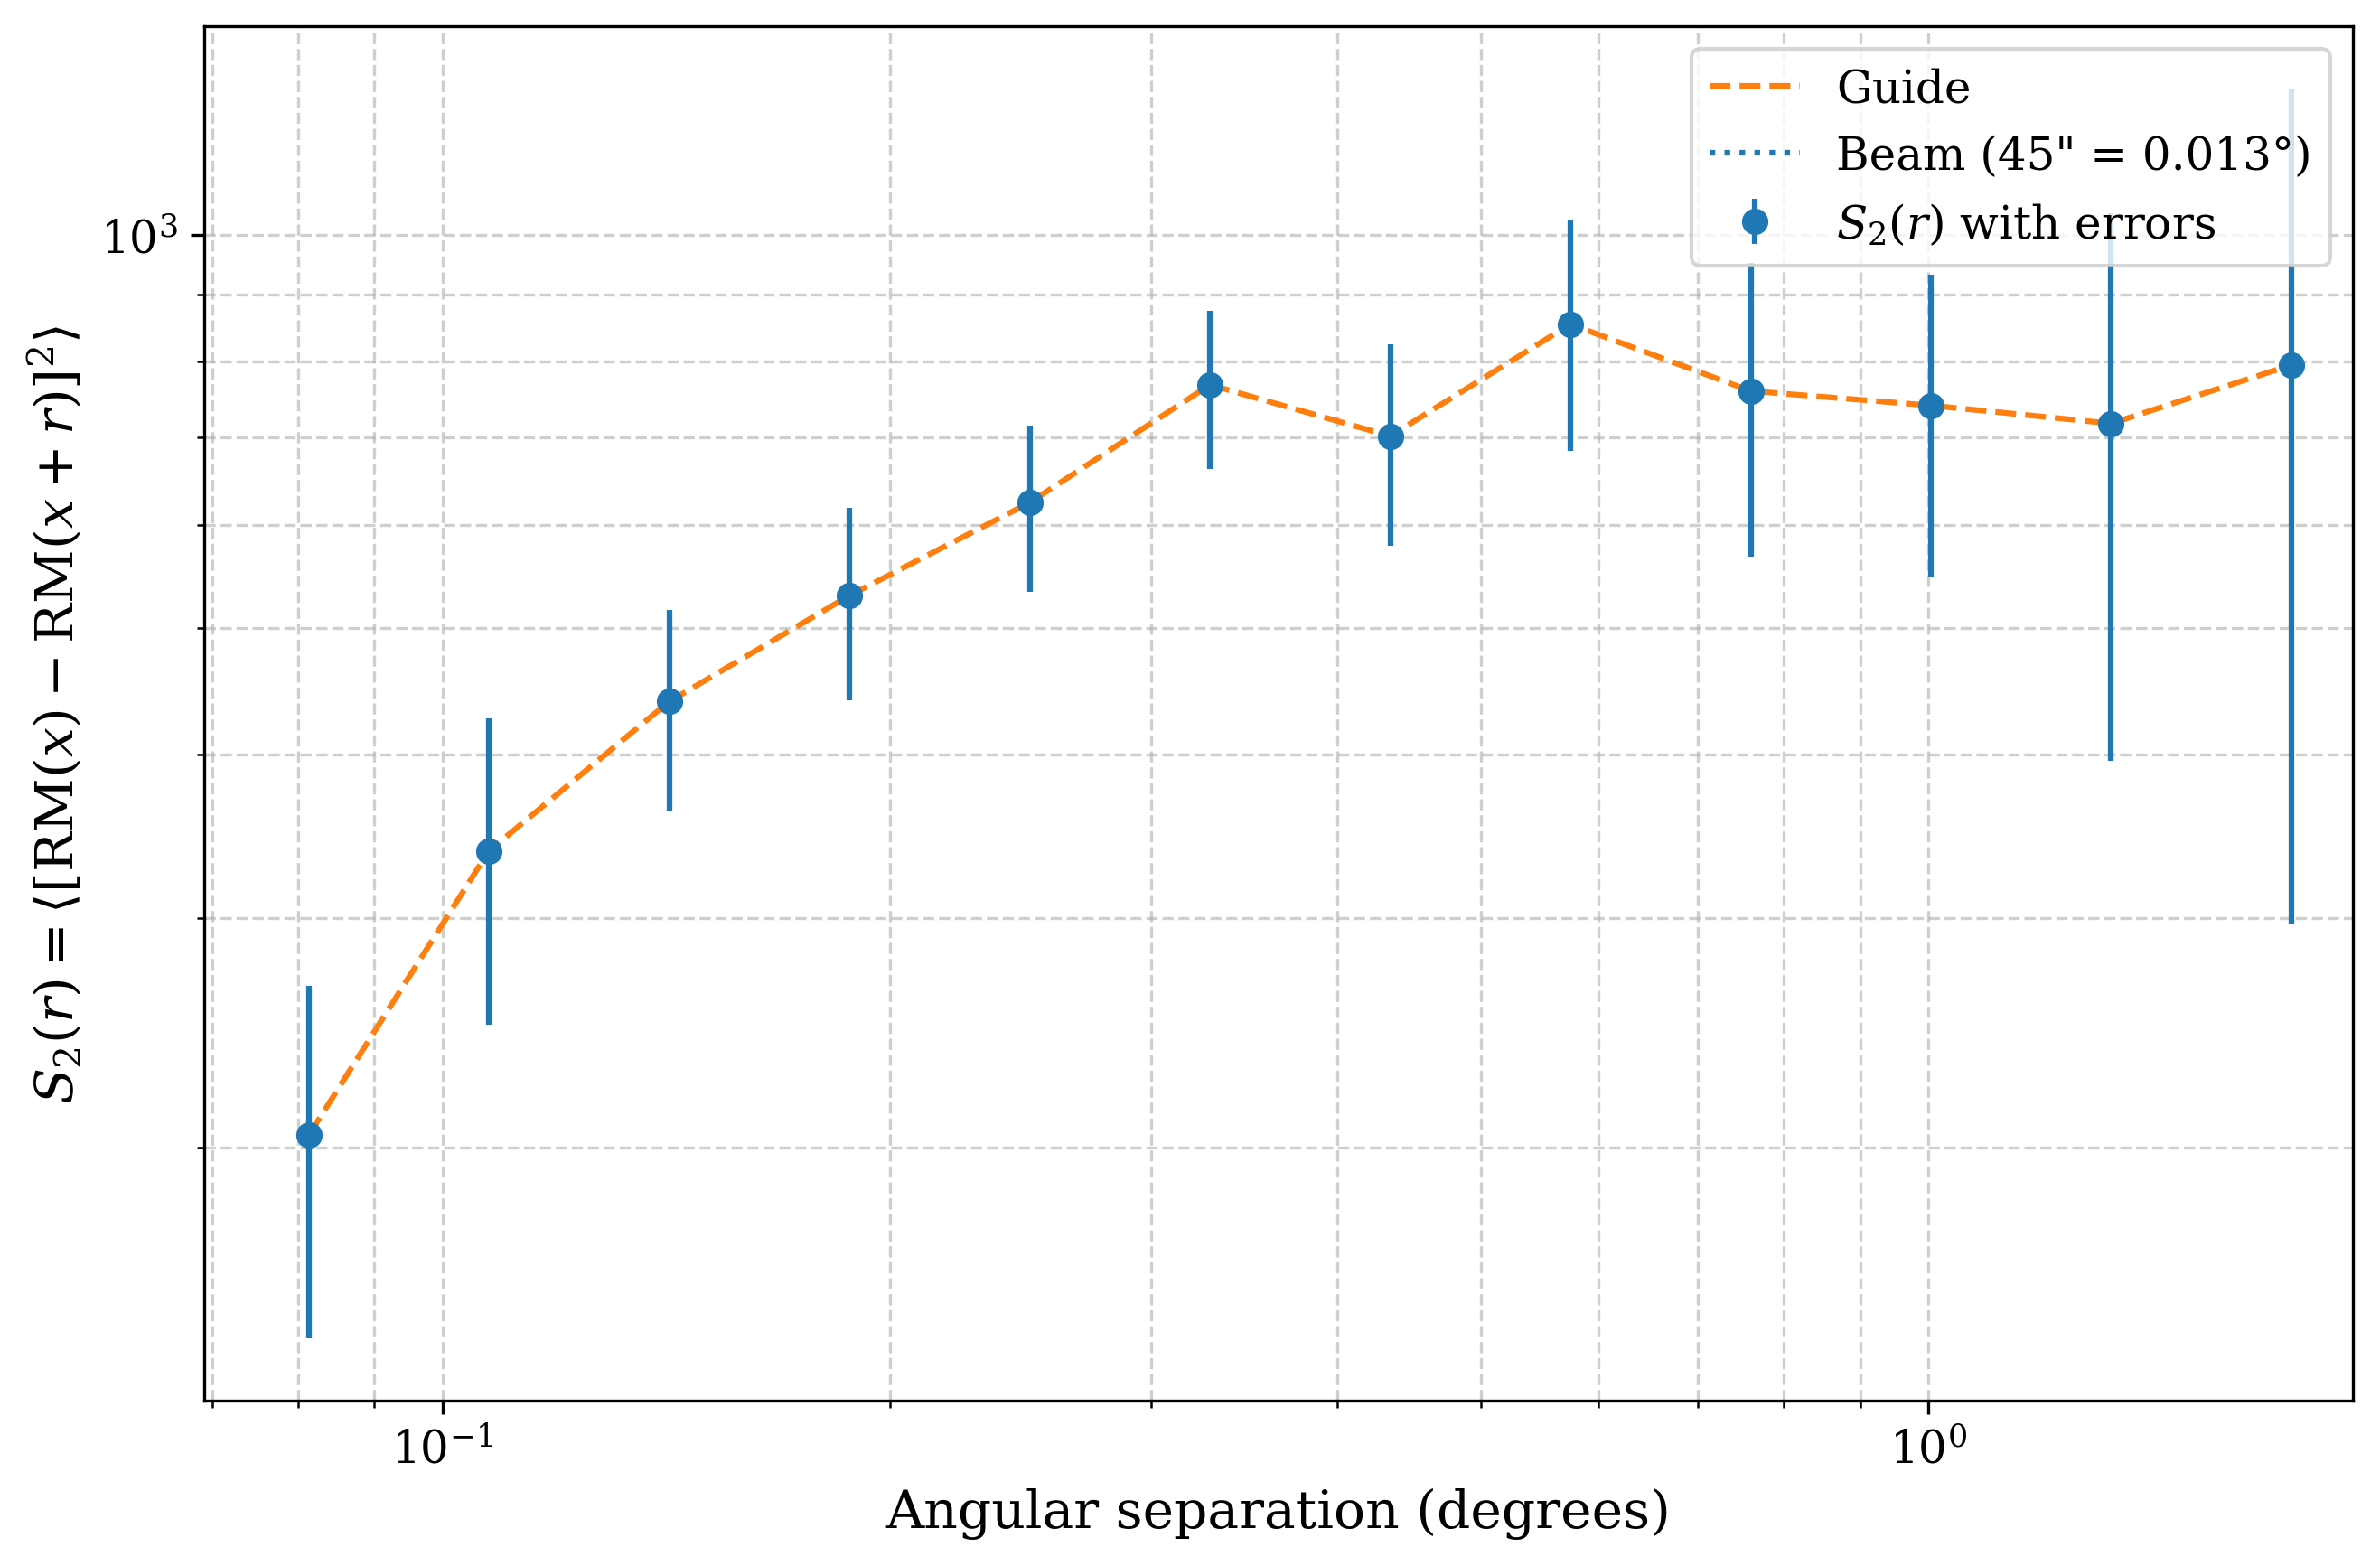


Binned structure function (including empty bins):
 bin_center_deg  num_pairs    S2  S2_err
        0.08128         22 204.5   61.58
         0.1075         29 337.7   88.97
         0.1421         73 439.2   76.75
         0.1879         92 529.5   89.01
         0.2485        149 623.8   90.55
         0.3286        258 767.7   106.2
         0.4345        460 701.4   123.2
         0.5745        651 854.3     171
         0.7596       1028 759.4   192.6
          1.004       1446 740.2   192.6
          1.328       2057 717.1   321.2
          1.756       2491 795.1   498.7


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree

# =========================
# Plot style
# =========================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False,
    'mathtext.fontset': 'dejavuserif',
    'mathtext.rm': 'serif',
})

# =========================
# Parameters
# =========================
INPUT_CSV = "../paper2/total/true_detections_full.csv"
SURVEY_AREA_DEG2 = 13.8
BEAM_ARCSEC = 45.0
BIN_MIN_DEG = 0.07
BIN_MAX_DEG = 2.0
N_BINS = 12
N_MC = 100
RANDOM_SEED = 42  # for reproducible MC errors

# =========================
# Load and clean catalog
# =========================
rm_df = pd.read_csv(INPUT_CSV)
rm_df = rm_df[['RA', 'DEC', 'RM', 'dRM']].copy()

# Handle RA/DEC that may be sexagesimal strings or decimals stored as strings
ra_str = rm_df['RA'].astype(str).str.strip()
dec_str = rm_df['DEC'].astype(str).str.strip()

# Detect rows that look like sexagesimal (have ":" or space-delimited components)
is_sexa = ra_str.str.contains("[: ]") | dec_str.str.contains("[: ]")

# Convert sexagesimal → degrees for those rows
if is_sexa.any():
    sc = SkyCoord(ra=ra_str[is_sexa].values,
                  dec=dec_str[is_sexa].values,
                  unit=(u.hourangle, u.deg),  # RA in hours, DEC in degrees
                  frame='icrs')
    rm_df.loc[is_sexa, 'RA'] = sc.ra.deg
    rm_df.loc[is_sexa, 'DEC'] = sc.dec.deg

# Coerce everything to numeric; drop any row with invalid or infinite values
for col in ['RA', 'DEC', 'RM', 'dRM']:
    rm_df[col] = pd.to_numeric(rm_df[col], errors='coerce')

before = len(rm_df)
rm_df = rm_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['RA', 'DEC', 'RM', 'dRM'])
after = len(rm_df)

print(f"Total RMs (loaded): {before} | After cleaning: {after} (dropped {before - after})")

# Ensure float dtype
rm_df[['RA', 'DEC', 'RM', 'dRM']] = rm_df[['RA', 'DEC', 'RM', 'dRM']].astype(float)

# =========================
# Beam info
# =========================
beam_arcsec = float(BEAM_ARCSEC)
beam_deg = beam_arcsec / 3600.0
print(f"\nBeam size: {beam_arcsec:.0f} arcsec ({beam_deg:.5f} degrees)\n")

# =========================
# Build KDTree
# =========================
skycoords = SkyCoord(ra=rm_df['RA'].values * u.deg, dec=rm_df['DEC'].values * u.deg)
positions = np.vstack([skycoords.ra.deg, skycoords.dec.deg]).T  # shape (N, 2)
tree = cKDTree(positions)

# =========================
# Define log-spaced bins
# =========================
bin_edges_deg = np.logspace(np.log10(BIN_MIN_DEG), np.log10(BIN_MAX_DEG), N_BINS + 1)
bin_centers_deg = 0.5 * (bin_edges_deg[:-1] + bin_edges_deg[1:])

# =========================
# Pairwise RM differences (de-duplicated)
# =========================
lags_deg = []
diffs_squared = []

# Query neighbors only within the maximum bin edge
r_max = bin_edges_deg[-1]

# To avoid double-counting pairs (i,j) and (j,i), only take j > i
for i in range(len(rm_df)):
    idxs_in_radius = tree.query_ball_point(positions[i], r=r_max)
    for j in idxs_in_radius:
        if j <= i:
            continue
        # Small-angle Euclidean approximation in degrees is fine for <= 2 deg
        dx = positions[i][0] - positions[j][0]
        dy = positions[i][1] - positions[j][1]
        dist_deg = np.hypot(dx, dy)
        # Only keep pairs that actually fall within r_max (cKDTree already does, but be explicit)
        if dist_deg <= r_max:
            diff_sq = (rm_df['RM'].iloc[i] - rm_df['RM'].iloc[j]) ** 2
            lags_deg.append(dist_deg)
            diffs_squared.append(diff_sq)

lags_deg = np.asarray(lags_deg, dtype=float)
diffs_squared = np.asarray(diffs_squared, dtype=float)

print(f"Total unique pairs within {r_max:.3f} deg: {len(lags_deg)}")

# =========================
# Structure function and MC error estimation
# =========================
structure_function = []
structure_error = []
num_pairs_per_bin = []

# Characteristic RM measurement error (used in MC model)
RM_error = float(np.nanmedian(rm_df['dRM'].values)) if len(rm_df) else np.nan
rng = np.random.default_rng(RANDOM_SEED)

for i in range(len(bin_edges_deg) - 1):
    in_bin = (lags_deg >= bin_edges_deg[i]) & (lags_deg < bin_edges_deg[i + 1])
    num_pairs = int(np.sum(in_bin))
    num_pairs_per_bin.append(num_pairs)

    if num_pairs > 0:
        s2 = float(np.mean(diffs_squared[in_bin]))
        structure_function.append(s2)

        # MC error: simulate RM differences with intrinsic Gaussian amp + measurement error
        Amp = np.sqrt(s2 / 2.0)  # since S2 ~ 2 * sigma_RM^2 for a stationary field
        sf_list = []

        # Vectorized MC draw for speed
        # Draw two independent fields per pair: (A1 + e1) - (A2 + e2)
        # A1,A2 ~ N(0, Amp); e1,e2 ~ N(0, RM_error)
        for _ in range(N_MC):
            A1 = rng.normal(loc=0.0, scale=Amp, size=num_pairs)
            A2 = rng.normal(loc=0.0, scale=Amp, size=num_pairs)
            e1 = rng.normal(loc=0.0, scale=RM_error, size=num_pairs)
            e2 = rng.normal(loc=0.0, scale=RM_error, size=num_pairs)
            diffs = (A1 + e1) - (A2 + e2)
            sf_list.append(np.mean(diffs ** 2))

        sf_arr = np.asarray(sf_list, dtype=float)

        # Finite sampling / area scaling
        Nscale = SURVEY_AREA_DEG2 / (0.25 * np.pi * (bin_centers_deg[i] ** 2))
        err = float(np.std(sf_arr, ddof=1) * np.sqrt((num_pairs + Nscale) / Nscale))
        structure_error.append(err)
    else:
        structure_function.append(np.nan)
        structure_error.append(np.nan)

structure_function = np.asarray(structure_function, dtype=float)
structure_error = np.asarray(structure_error, dtype=float)
num_pairs_per_bin = np.asarray(num_pairs_per_bin, dtype=int)

# =========================
# Filter for plotting
# =========================
valid = num_pairs_per_bin > 0
x = bin_centers_deg[valid]
y = structure_function[valid]
yerr = structure_error[valid]

# =========================
# Plot
# =========================
plt.figure(figsize=(9, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', label=r'$S_2(r)$ with errors')
plt.loglog(x, y, '--', label='Guide')
plt.axvline(beam_deg, linestyle=':', label=f'Beam ({beam_arcsec:.0f}" = {beam_deg:.3f}°)')

plt.xlabel(r"Angular separation (degrees)")
plt.ylabel(r"$S_2(r) = \langle [\mathrm{RM}(x) - \mathrm{RM}(x+r)]^2 \rangle$")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
if len(x):
    plt.xlim(x.min() * 0.85, x.max() * 1.1)
plt.tight_layout()
plt.show()

# =========================
# Optional: print a small table for sanity check
# =========================
summary = pd.DataFrame({
    "bin_center_deg": bin_centers_deg,
    "num_pairs": num_pairs_per_bin,
    "S2": structure_function,
    "S2_err": structure_error
})
print("\nBinned structure function (including empty bins):")
print(summary.to_string(index=False, float_format=lambda v: f"{v:.4g}"))


# J Errrobars

Total RMs (loaded): 189 | After cleaning: 188 (dropped 1)

Beam size: 45 arcsec (0.01250 degrees)

Total unique pairs within 2.000 deg: 8793

Structure function flattens around: 0.378 degrees
Slope (β) of S2(r) ∝ r^β: 0.88 ± 0.10


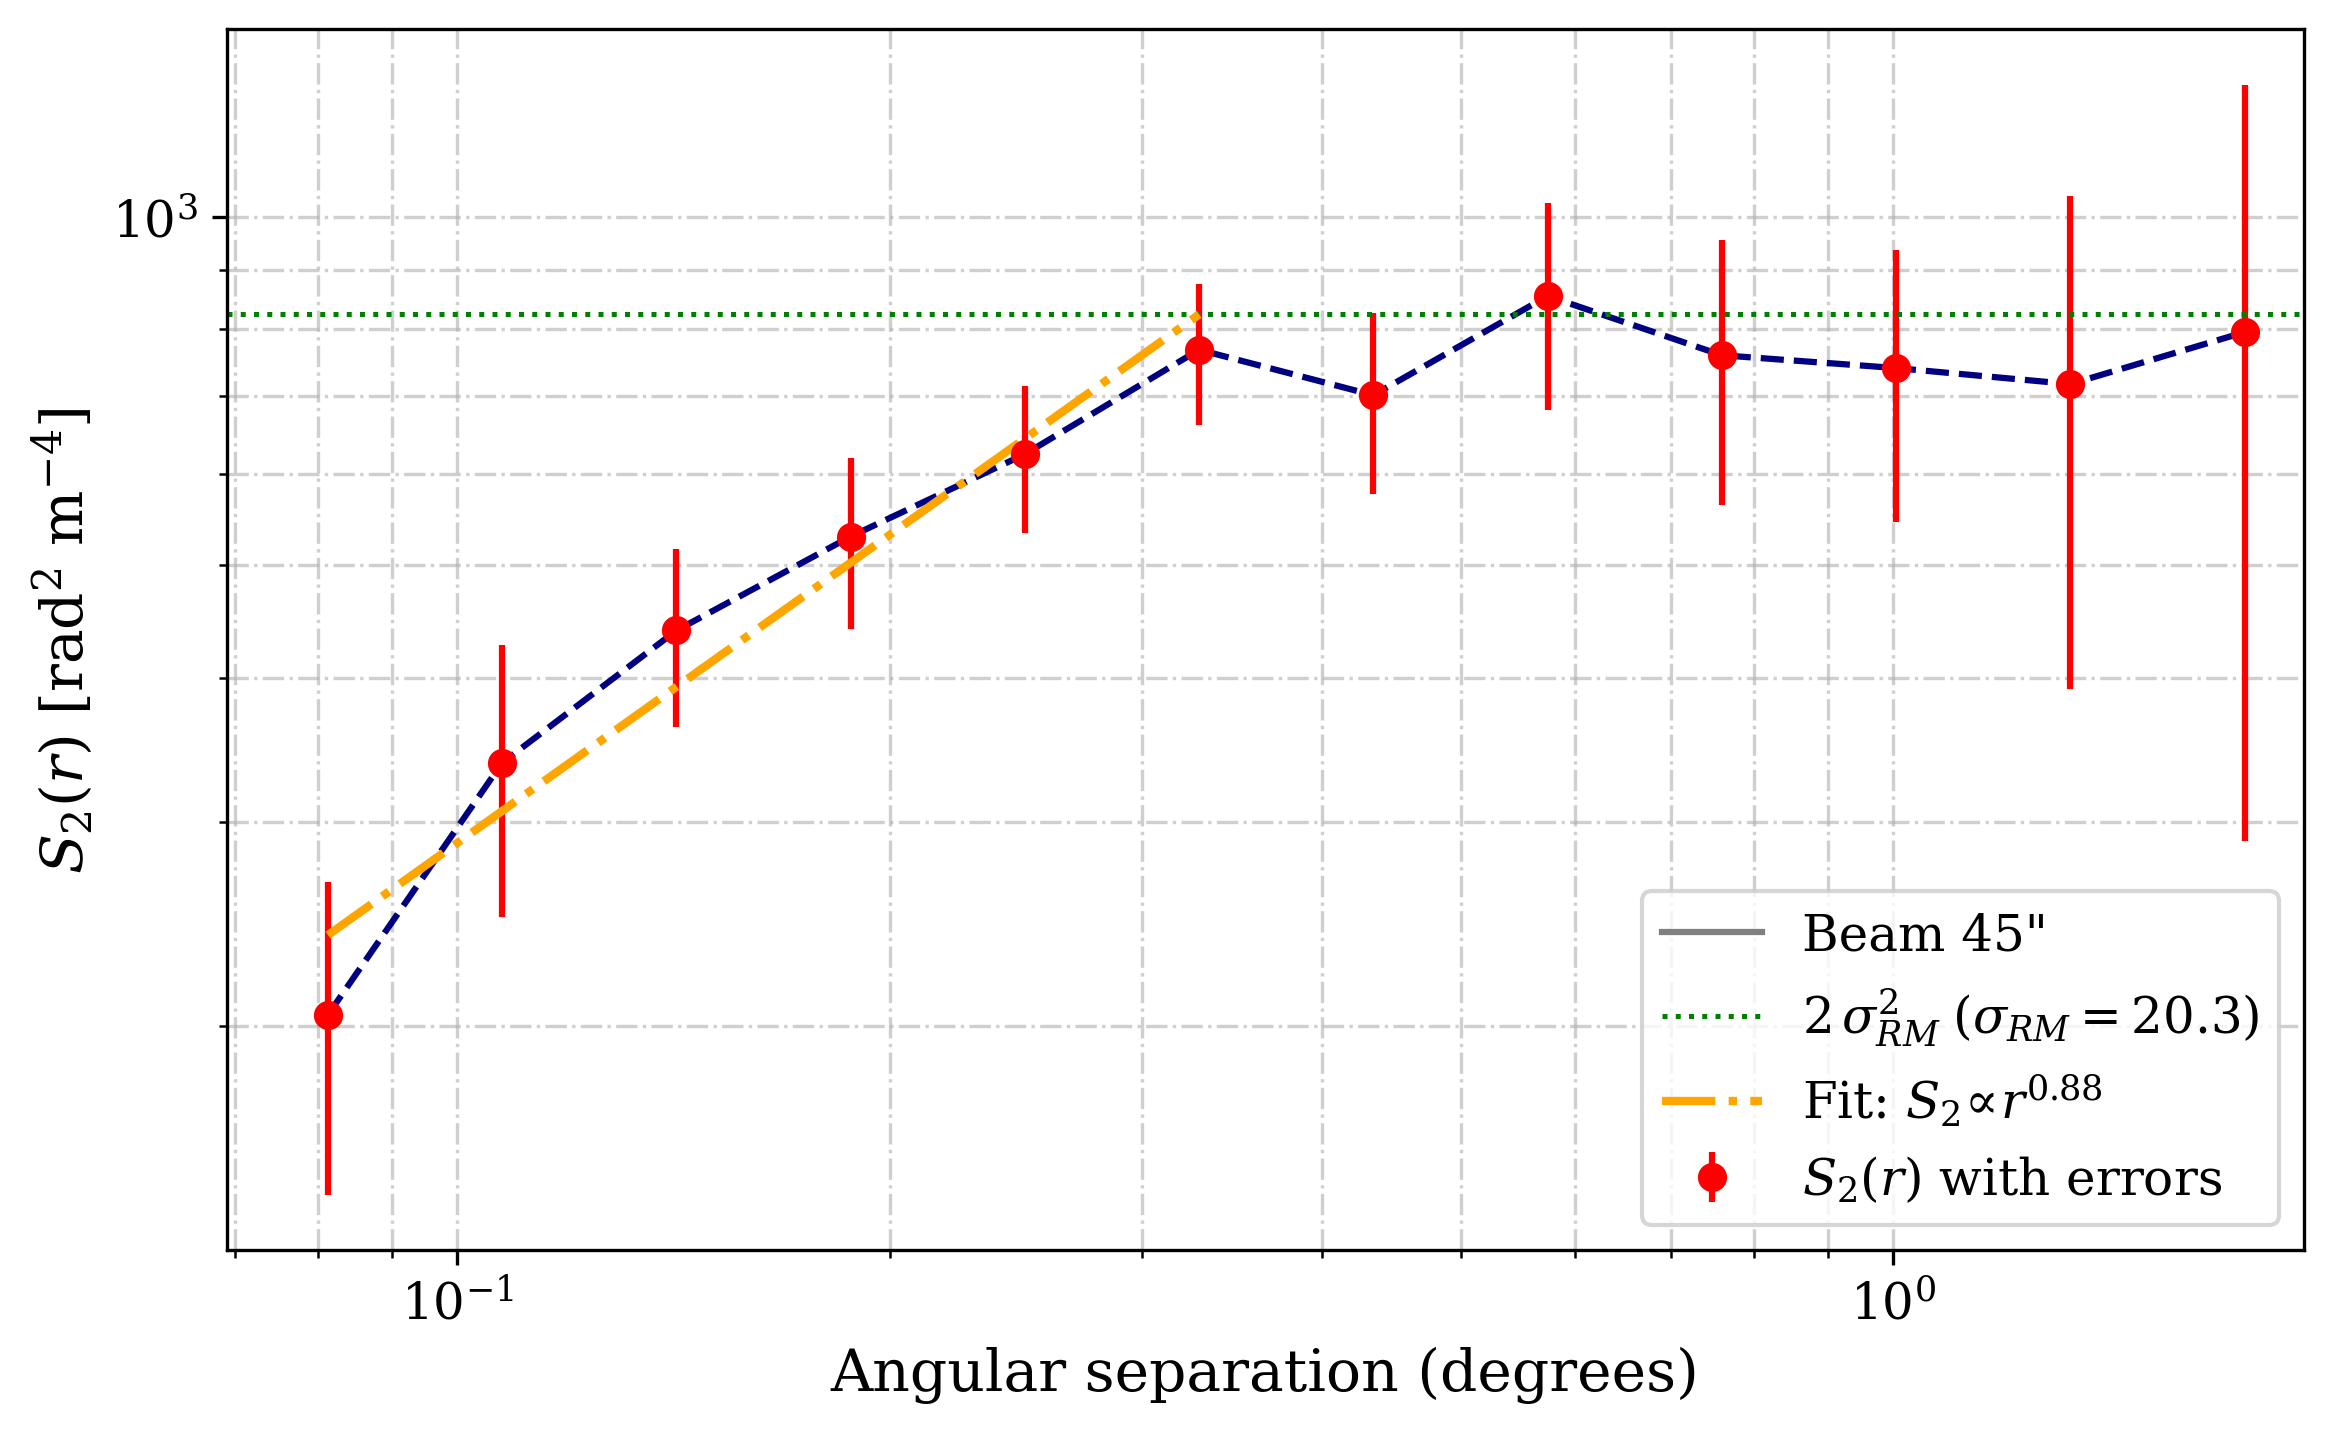

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree
from scipy.stats import linregress

# =====================================
# Plot style
# =====================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False,
    'mathtext.fontset': 'dejavuserif',
    'mathtext.rm': 'serif',
})

# =====================================
# Parameters
# =====================================
INPUT_CSV = "../paper2/total/true_detections_full.csv"
OUTPUT_PNG = "../paper1/figs/structurefunction.png"

BEAM_ARCSEC = 45.0
BIN_MIN_DEG, BIN_MAX_DEG, N_BINS = 0.07, 2.0, 12
N_MC = 100
OMEGA_SURVEY_DEG2 = 13.4
RANDOM_SEED = 42

# If you want to use a fixed sigma_RM for the green reference line, set here.
# Otherwise set to None to compute from data (stdev of RM).
FIXED_SIGMA_RM = 20.3  # or None

# Range to fit the power law (log-log)
FIT_MIN_DEG, FIT_MAX_DEG = 0.07, 0.4
SLOPE_FLAT_THRESHOLD = 0.1  # flattening criterion in d logS2 / d logr

# =====================================
# Load & CLEAN catalog (robust RA/DEC parsing)
# =====================================
rm_df = pd.read_csv(INPUT_CSV)
rm_df = rm_df[['RA', 'DEC', 'RM', 'dRM']].copy()

# Convert RA/DEC that may be sexagesimal or strings → float degrees
ra_str = rm_df['RA'].astype(str).str.strip()
dec_str = rm_df['DEC'].astype(str).str.strip()
is_sexa = ra_str.str.contains("[: ]") | dec_str.str.contains("[: ]")

if is_sexa.any():
    sc = SkyCoord(ra=ra_str[is_sexa].values,
                  dec=dec_str[is_sexa].values,
                  unit=(u.hourangle, u.deg),  # RA in hours, DEC in degrees
                  frame='icrs')
    rm_df.loc[is_sexa, 'RA'] = sc.ra.deg
    rm_df.loc[is_sexa, 'DEC'] = sc.dec.deg

# Coerce all to numeric; drop invalid rows
for col in ['RA', 'DEC', 'RM', 'dRM']:
    rm_df[col] = pd.to_numeric(rm_df[col], errors='coerce')

before = len(rm_df)
rm_df = rm_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['RA', 'DEC', 'RM', 'dRM'])
after = len(rm_df)

print(f"Total RMs (loaded): {before} | After cleaning: {after} (dropped {before - after})")

rm_df[['RA', 'DEC', 'RM', 'dRM']] = rm_df[['RA', 'DEC', 'RM', 'dRM']].astype(float)

# =====================================
# Beam info
# =====================================
beam_deg = BEAM_ARCSEC / 3600.0
print(f"\nBeam size: {BEAM_ARCSEC:.0f} arcsec ({beam_deg:.5f} degrees)\n")

# =====================================
# Build KDTree of sky positions
# =====================================
skycoords = SkyCoord(ra=rm_df['RA'].values * u.deg, dec=rm_df['DEC'].values * u.deg)
positions = np.vstack([skycoords.ra.deg, skycoords.dec.deg]).T  # (N, 2)
tree = cKDTree(positions)

# =====================================
# Define log-spaced bins
# =====================================
bin_edges_deg = np.logspace(np.log10(BIN_MIN_DEG), np.log10(BIN_MAX_DEG), N_BINS + 1)
bin_centers_deg = 0.5 * (bin_edges_deg[:-1] + bin_edges_deg[1:])

# =====================================
# Pairwise RM differences, unique pairs only
# =====================================
lags_deg = []
diffs_squared = []

r_max = bin_edges_deg[-1]
for i in range(len(rm_df)):
    idxs = tree.query_ball_point(positions[i], r=r_max)
    for j in idxs:
        if j <= i:  # avoid self-pairs and double counting
            continue
        dx = positions[i][0] - positions[j][0]
        dy = positions[i][1] - positions[j][1]
        dist_deg = np.hypot(dx, dy)
        if dist_deg <= r_max:
            diff_sq = (rm_df['RM'].iloc[i] - rm_df['RM'].iloc[j])**2
            lags_deg.append(dist_deg)
            diffs_squared.append(diff_sq)

lags_deg = np.asarray(lags_deg, dtype=float)
diffs_squared = np.asarray(diffs_squared, dtype=float)
print(f"Total unique pairs within {r_max:.3f} deg: {len(lags_deg)}")

# =====================================
# Structure function & MC errors
# =====================================
rng = np.random.default_rng(RANDOM_SEED)
RM_error = float(np.nanmedian(rm_df['dRM'].values)) if len(rm_df) else np.nan

structure_function = []
structure_error = []
num_pairs_per_bin = []

for i in range(len(bin_edges_deg) - 1):
    in_bin = (lags_deg >= bin_edges_deg[i]) & (lags_deg < bin_edges_deg[i+1])
    num_pairs = int(np.sum(in_bin))
    num_pairs_per_bin.append(num_pairs)

    if num_pairs > 0:
        s2 = float(np.mean(diffs_squared[in_bin]))
        structure_function.append(s2)

        # MC error model: intrinsic Gaussian field + measurement errors
        Amp = np.sqrt(max(s2, 0.0) / 2.0)
        sf_list = []
        for _ in range(N_MC):
            A1 = rng.normal(0.0, Amp, size=num_pairs)
            A2 = rng.normal(0.0, Amp, size=num_pairs)
            e1 = rng.normal(0.0, RM_error, size=num_pairs)
            e2 = rng.normal(0.0, RM_error, size=num_pairs)
            diffs = (A1 + e1) - (A2 + e2)
            sf_list.append(np.mean(diffs**2))
        sf_arr = np.asarray(sf_list, dtype=float)

        Nscale = OMEGA_SURVEY_DEG2 / (0.25 * np.pi * (bin_centers_deg[i]**2))
        err = float(np.std(sf_arr, ddof=1) * np.sqrt((num_pairs + Nscale) / Nscale))
        structure_error.append(err)
    else:
        structure_function.append(np.nan)
        structure_error.append(np.nan)

structure_function = np.asarray(structure_function, dtype=float)
structure_error = np.asarray(structure_error, dtype=float)
num_pairs_per_bin = np.asarray(num_pairs_per_bin, dtype=int)

# =====================================
# Filter bins for plotting / analysis
# =====================================
valid = (num_pairs_per_bin > 0) & np.isfinite(structure_function) & (structure_function > 0)
x = bin_centers_deg[valid]
y = structure_function[valid]
yerr = structure_error[valid]

if len(x) == 0:
    raise RuntimeError("No valid bins to plot or analyze. Check your input catalog or binning.")

# =====================================
# Flattening scale from local slope in log-log space
# =====================================
log_r = np.log10(x)
log_S2 = np.log10(y)

# local slopes on midpoints
local_slopes = np.diff(log_S2) / np.diff(log_r)
mid_r = 10 ** ((log_r[1:] + log_r[:-1]) / 2.0)

flat_indices = np.where(local_slopes < SLOPE_FLAT_THRESHOLD)[0]
if len(flat_indices) > 0:
    flattening_scale = float(mid_r[flat_indices[0]])
    print(f"\nStructure function flattens around: {flattening_scale:.3f} degrees")
else:
    print("\nNo clear flattening detected in the current range.")

# =====================================
# Power-law fit on the steep part
# =====================================
fit_mask = (x >= FIT_MIN_DEG) & (x <= FIT_MAX_DEG) & np.isfinite(y) & (y > 0)
x_fit = x[fit_mask]
y_fit = y[fit_mask]

if len(x_fit) >= 2:
    logx = np.log10(x_fit)
    logy = np.log10(y_fit)
    slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
    print(f"Slope (β) of S2(r) ∝ r^β: {slope:.2f} ± {std_err:.2f}")
    x_model = np.logspace(np.log10(x_fit.min()), np.log10(x_fit.max()), 200)
    y_model = 10**intercept * x_model**slope
else:
    print("Not enough points in the selected fit range to perform a reliable fit.")
    slope, intercept, std_err = np.nan, np.nan, np.nan
    x_model, y_model = np.array([]), np.array([])

# =====================================
# Reference line for uncorrelated limit: 2 * sigma_RM^2
# =====================================
if FIXED_SIGMA_RM is not None:
    sigma_RM = float(FIXED_SIGMA_RM)
else:
    # robust estimate from the data (you can tweak this)
    sigma_RM = float(np.nanstd(rm_df['RM'].values, ddof=1))
ref_value = 2.0 * (sigma_RM**2)

# =====================================
# Plot
# =====================================
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='red', label=r'$S_2(r)$ with errors')
plt.loglog(x, y, '--', color='navy')
plt.axvline(beam_deg, color='gray', linestyle='-', label=f'Beam {BEAM_ARCSEC:.0f}"')

plt.axhline(ref_value, color='green', linestyle=':', linewidth=1.2,
            label=rf'$2\,\sigma_{{RM}}^2 \;(\sigma_{{RM}}={sigma_RM:.1f})$')

if len(x_model):
    plt.loglog(x_model, y_model, color='orange', linestyle='-.', linewidth=2,
               label=fr'Fit: $S_2\!\propto\! r^{{{slope:.2f}}}$')

plt.xlabel(r"Angular separation (degrees)")
plt.ylabel(r"$S_2(r)$ [rad$^{2}$ m$^{-4}$]")
plt.grid(True, which='both', linestyle='-.', alpha=0.6)
plt.legend(loc='lower right')
plt.xlim(x.min() * 0.85, x.max() * 1.1)
plt.tight_layout()

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_PNG), exist_ok=True)
plt.savefig(OUTPUT_PNG)
plt.show()


Total RMs (loaded): 189 | After cleaning: 188 (dropped 1)

Beam size: 45 arcsec (0.01250 degrees)

Total unique pairs within 2.000 deg: 8793

Structure function flattens around: 0.378 degrees
Slope (β) of S2(r) ∝ r^β: 0.88 ± 0.10

Using sigma_RM = mean(dRM) = 5.583 rad m^-2


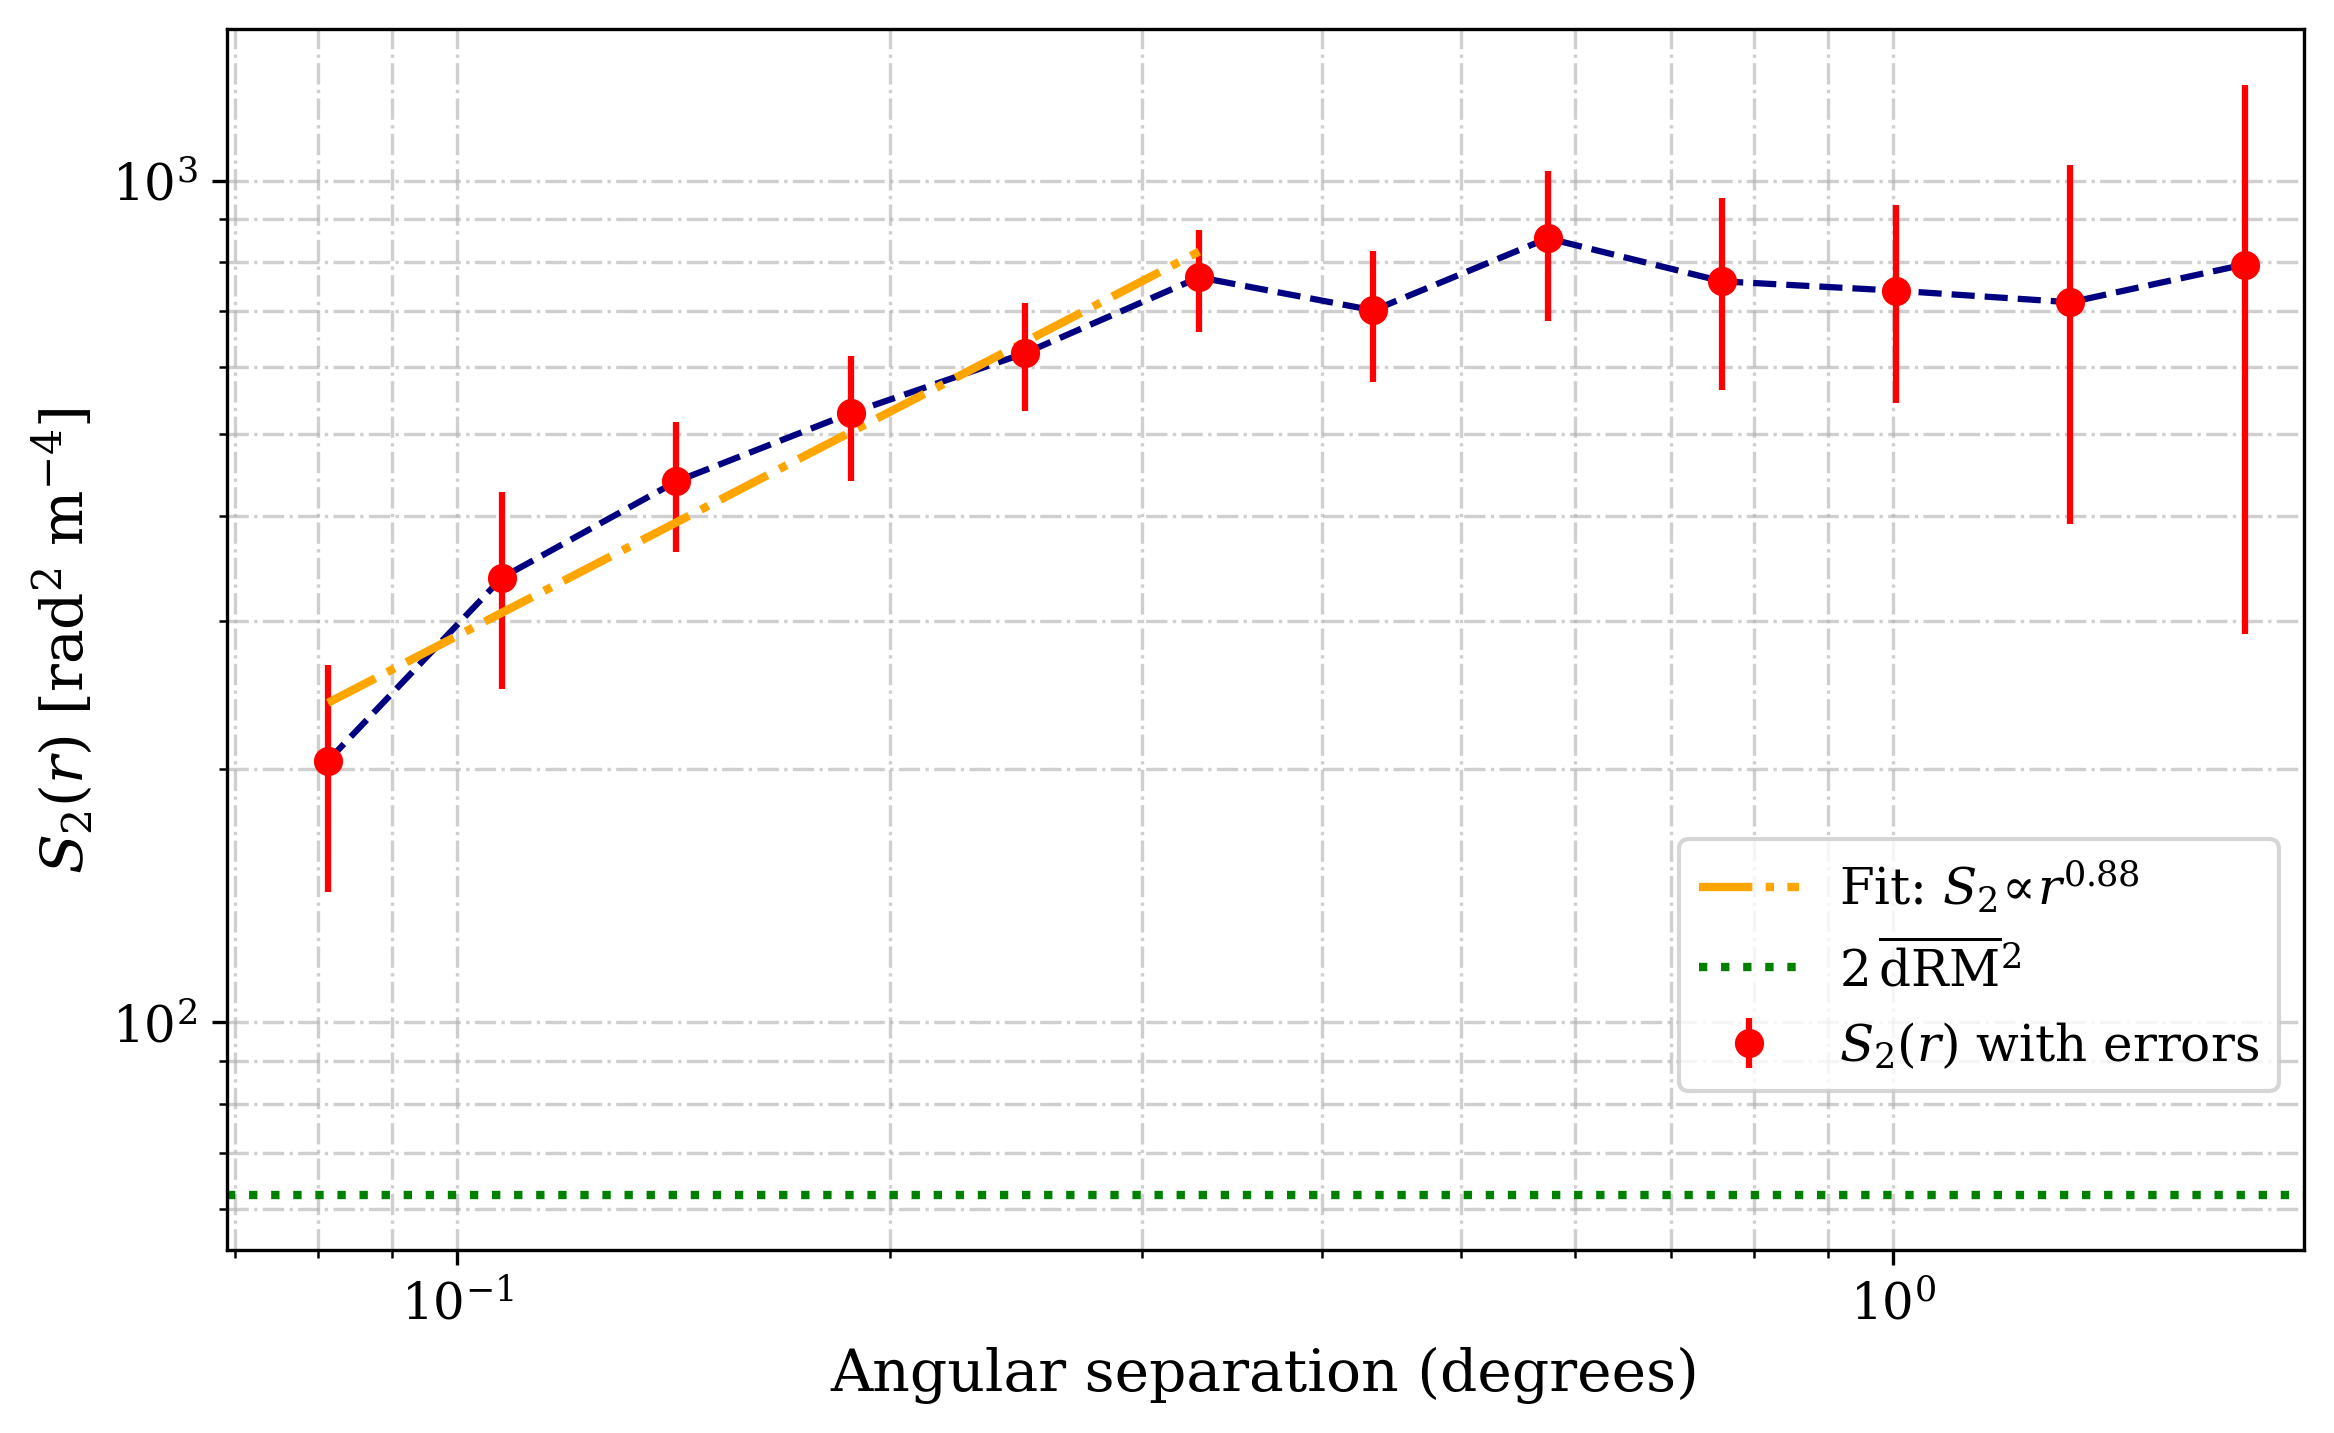

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree
from scipy.stats import linregress

# =====================================
# Plot style
# =====================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False,
    'mathtext.fontset': 'dejavuserif',
    'mathtext.rm': 'serif',
})

# =====================================
# Parameters
# =====================================
INPUT_CSV = "../paper2/total/true_detections_full.csv"
OUTPUT_PNG = "../paper1/figs/structurefunction.png"

BEAM_ARCSEC = 45.0
BIN_MIN_DEG, BIN_MAX_DEG, N_BINS = 0.07, 2.0, 12
N_MC = 100
OMEGA_SURVEY_DEG2 = 13.4
RANDOM_SEED = 42

# Range to fit the power law (log-log)
FIT_MIN_DEG, FIT_MAX_DEG = 0.07, 0.4
SLOPE_FLAT_THRESHOLD = 0.1  # flattening criterion in d logS2 / d logr

# =====================================
# Load & CLEAN catalog (robust RA/DEC parsing)
# =====================================
rm_df = pd.read_csv(INPUT_CSV)
rm_df = rm_df[['RA', 'DEC', 'RM', 'dRM']].copy()

# Convert RA/DEC that may be sexagesimal or strings → float degrees
ra_str = rm_df['RA'].astype(str).str.strip()
dec_str = rm_df['DEC'].astype(str).str.strip()
is_sexa = ra_str.str.contains("[: ]") | dec_str.str.contains("[: ]")

if is_sexa.any():
    sc = SkyCoord(ra=ra_str[is_sexa].values,
                  dec=dec_str[is_sexa].values,
                  unit=(u.hourangle, u.deg),  # RA in hours, DEC in degrees
                  frame='icrs')
    rm_df.loc[is_sexa, 'RA'] = sc.ra.deg
    rm_df.loc[is_sexa, 'DEC'] = sc.dec.deg

# Coerce all to numeric; drop invalid rows
for col in ['RA', 'DEC', 'RM', 'dRM']:
    rm_df[col] = pd.to_numeric(rm_df[col], errors='coerce')

before = len(rm_df)
rm_df = rm_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['RA', 'DEC', 'RM', 'dRM'])
after = len(rm_df)

print(f"Total RMs (loaded): {before} | After cleaning: {after} (dropped {before - after})")

rm_df[['RA', 'DEC', 'RM', 'dRM']] = rm_df[['RA', 'DEC', 'RM', 'dRM']].astype(float)

# =====================================
# Beam info
# =====================================
beam_deg = BEAM_ARCSEC / 3600.0
print(f"\nBeam size: {BEAM_ARCSEC:.0f} arcsec ({beam_deg:.5f} degrees)\n")

# =====================================
# Build KDTree of sky positions
# =====================================
skycoords = SkyCoord(ra=rm_df['RA'].values * u.deg, dec=rm_df['DEC'].values * u.deg)
positions = np.vstack([skycoords.ra.deg, skycoords.dec.deg]).T  # (N, 2)
tree = cKDTree(positions)

# =====================================
# Define log-spaced bins
# =====================================
bin_edges_deg = np.logspace(np.log10(BIN_MIN_DEG), np.log10(BIN_MAX_DEG), N_BINS + 1)
bin_centers_deg = 0.5 * (bin_edges_deg[:-1] + bin_edges_deg[1:])

# =====================================
# Pairwise RM differences, unique pairs only
# =====================================
lags_deg = []
diffs_squared = []

r_max = bin_edges_deg[-1]
for i in range(len(rm_df)):
    idxs = tree.query_ball_point(positions[i], r=r_max)
    for j in idxs:
        if j <= i:  # avoid self-pairs and double counting
            continue
        dx = positions[i][0] - positions[j][0]
        dy = positions[i][1] - positions[j][1]
        dist_deg = np.hypot(dx, dy)
        if dist_deg <= r_max:
            diff_sq = (rm_df['RM'].iloc[i] - rm_df['RM'].iloc[j])**2
            lags_deg.append(dist_deg)
            diffs_squared.append(diff_sq)

lags_deg = np.asarray(lags_deg, dtype=float)
diffs_squared = np.asarray(diffs_squared, dtype=float)
print(f"Total unique pairs within {r_max:.3f} deg: {len(lags_deg)}")

# =====================================
# Structure function & MC errors
# =====================================
rng = np.random.default_rng(RANDOM_SEED)
RM_error = float(np.nanmedian(rm_df['dRM'].values)) if len(rm_df) else np.nan

structure_function = []
structure_error = []
num_pairs_per_bin = []

for i in range(len(bin_edges_deg) - 1):
    in_bin = (lags_deg >= bin_edges_deg[i]) & (lags_deg < bin_edges_deg[i+1])
    num_pairs = int(np.sum(in_bin))
    num_pairs_per_bin.append(num_pairs)

    if num_pairs > 0:
        s2 = float(np.mean(diffs_squared[in_bin]))
        structure_function.append(s2)

        # MC error model: intrinsic Gaussian field + measurement errors
        Amp = np.sqrt(max(s2, 0.0) / 2.0)
        sf_list = []
        for _ in range(N_MC):
            A1 = rng.normal(0.0, Amp, size=num_pairs)
            A2 = rng.normal(0.0, Amp, size=num_pairs)
            e1 = rng.normal(0.0, RM_error, size=num_pairs)
            e2 = rng.normal(0.0, RM_error, size=num_pairs)
            diffs = (A1 + e1) - (A2 + e2)
            sf_list.append(np.mean(diffs**2))
        sf_arr = np.asarray(sf_list, dtype=float)

        Nscale = OMEGA_SURVEY_DEG2 / (0.25 * np.pi * (bin_centers_deg[i]**2))
        err = float(np.std(sf_arr, ddof=1) * np.sqrt((num_pairs + Nscale) / Nscale))
        structure_error.append(err)
    else:
        structure_function.append(np.nan)
        structure_error.append(np.nan)

structure_function = np.asarray(structure_function, dtype=float)
structure_error = np.asarray(structure_error, dtype=float)
num_pairs_per_bin = np.asarray(num_pairs_per_bin, dtype=int)

# =====================================
# Filter bins for plotting / analysis
# =====================================
valid = (num_pairs_per_bin > 0) & np.isfinite(structure_function) & (structure_function > 0)
x = bin_centers_deg[valid]
y = structure_function[valid]
yerr = structure_error[valid]

if len(x) == 0:
    raise RuntimeError("No valid bins to plot or analyze. Check your input catalog or binning.")

# =====================================
# Flattening scale from local slope in log-log space
# =====================================
log_r = np.log10(x)
log_S2 = np.log10(y)

# local slopes on midpoints
local_slopes = np.diff(log_S2) / np.diff(log_r)
mid_r = 10 ** ((log_r[1:] + log_r[:-1]) / 2.0)

flat_indices = np.where(local_slopes < SLOPE_FLAT_THRESHOLD)[0]
if len(flat_indices) > 0:
    flattening_scale = float(mid_r[flat_indices[0]])
    print(f"\nStructure function flattens around: {flattening_scale:.3f} degrees")
else:
    print("\nNo clear flattening detected in the current range.")

# =====================================
# Power-law fit on the steep part
# =====================================
fit_mask = (x >= FIT_MIN_DEG) & (x <= FIT_MAX_DEG) & np.isfinite(y) & (y > 0)
x_fit = x[fit_mask]
y_fit = y[fit_mask]

if len(x_fit) >= 2:
    logx = np.log10(x_fit)
    logy = np.log10(y_fit)
    slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
    print(f"Slope (β) of S2(r) ∝ r^β: {slope:.2f} ± {std_err:.2f}")
    x_model = np.logspace(np.log10(x_fit.min()), np.log10(x_fit.max()), 200)
    y_model = 10**intercept * x_model**slope
else:
    print("Not enough points in the selected fit range to perform a reliable fit.")
    slope, intercept, std_err = np.nan, np.nan, np.nan
    x_model, y_model = np.array([]), np.array([])

# =====================================
# Reference line for uncorrelated limit: 2 * sigma_RM^2
# Here sigma_RM = mean(dRM) from the catalog
# =====================================
sigma_RM = float(np.nanmean(rm_df['dRM'].values))
sigma_RM = 2*(sigma_RM**2)
print(f"\nUsing sigma_RM = mean(dRM) = {sigma_RM:.3f} rad m^-2")
ref_value = 2.0 * (sigma_RM**2)

# =====================================
# Plot
# =====================================
plt.figure(figsize=(8, 5))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='red', label=r'$S_2(r)$ with errors')
plt.loglog(x, y, '--', color='navy')
plt.axvline(beam_deg, color='gray', linestyle='-')


if len(x_model):
    plt.loglog(x_model, y_model, color='orange', linestyle='-.', linewidth=2,
               label=fr'Fit: $S_2\!\propto\! r^{{{slope:.2f}}}$')

plt.axhline(ref_value, color='green', linestyle=':', linewidth=2,
            label=r'$2\,\overline{\mathrm{dRM}}^{2}$')
    

plt.xlabel(r"Angular separation (degrees)")
plt.ylabel(r"$S_2(r)$ [rad$^{2}$ m$^{-4}$]")
plt.grid(True, which='both', linestyle='-.', alpha=0.6)
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, 0.11)   # decrease the second number to raise upward
)

plt.xlim(x.min() * 0.85, x.max() * 1.1)
plt.tight_layout()

# Ensure output directory exists
os.makedirs(os.path.dirname(OUTPUT_PNG), exist_ok=True)
plt.savefig(OUTPUT_PNG)
plt.show()


In [6]:
import pandas as pd
import numpy as np

# Path to your RM catalog
INPUT_CSV = "../paper2/total/true_detections_full.csv"

# Load the catalog
df = pd.read_csv(INPUT_CSV)

# Convert dRM column to numeric
df["dRM"] = pd.to_numeric(df["dRM"], errors="coerce")

# Drop invalid values (NaN, inf)
clean = df["dRM"].replace([np.inf, -np.inf], np.nan).dropna()

# Compute statistics
mean_dRM = clean.mean()
median_dRM = clean.median()
std_dRM = clean.std()

print(f"Number of valid dRM values: {len(clean)}")
print(f"Mean dRM = {mean_dRM:.3f} rad/m^2")
print(f"Median dRM = {median_dRM:.3f} rad/m^2")
print(f"Std of dRM = {std_dRM:.3f} rad/m^2")


Number of valid dRM values: 188
Mean dRM = 1.671 rad/m^2
Median dRM = 1.505 rad/m^2
Std of dRM = 1.136 rad/m^2


# Monte Carlo Method for errorbars

Total RMs: 194
Beam size: 45 arcsec (0.01250 degrees)
Bin   Range (deg)            Center (deg)    N pairs    S2(r)                ± Error   
-----------------------------------------------------------------------------------------------
0     0.0693–0.0854         0.07737       46         1.00016e+02       1.82838e+01
1     0.0854–0.1053         0.09539       50         4.45961e+02       2.61059e+01
2     0.1053–0.1299         0.11760       72         3.82745e+02       2.51955e+01
3     0.1299–0.1601         0.14498       132        5.25758e+02       2.37105e+01
4     0.1601–0.1974         0.17874       138        8.35042e+02       3.65430e+01
5     0.1974–0.2433         0.22036       168        7.59402e+02       2.88807e+01
6     0.2433–0.3000         0.27167       300        9.39540e+02       2.84537e+01


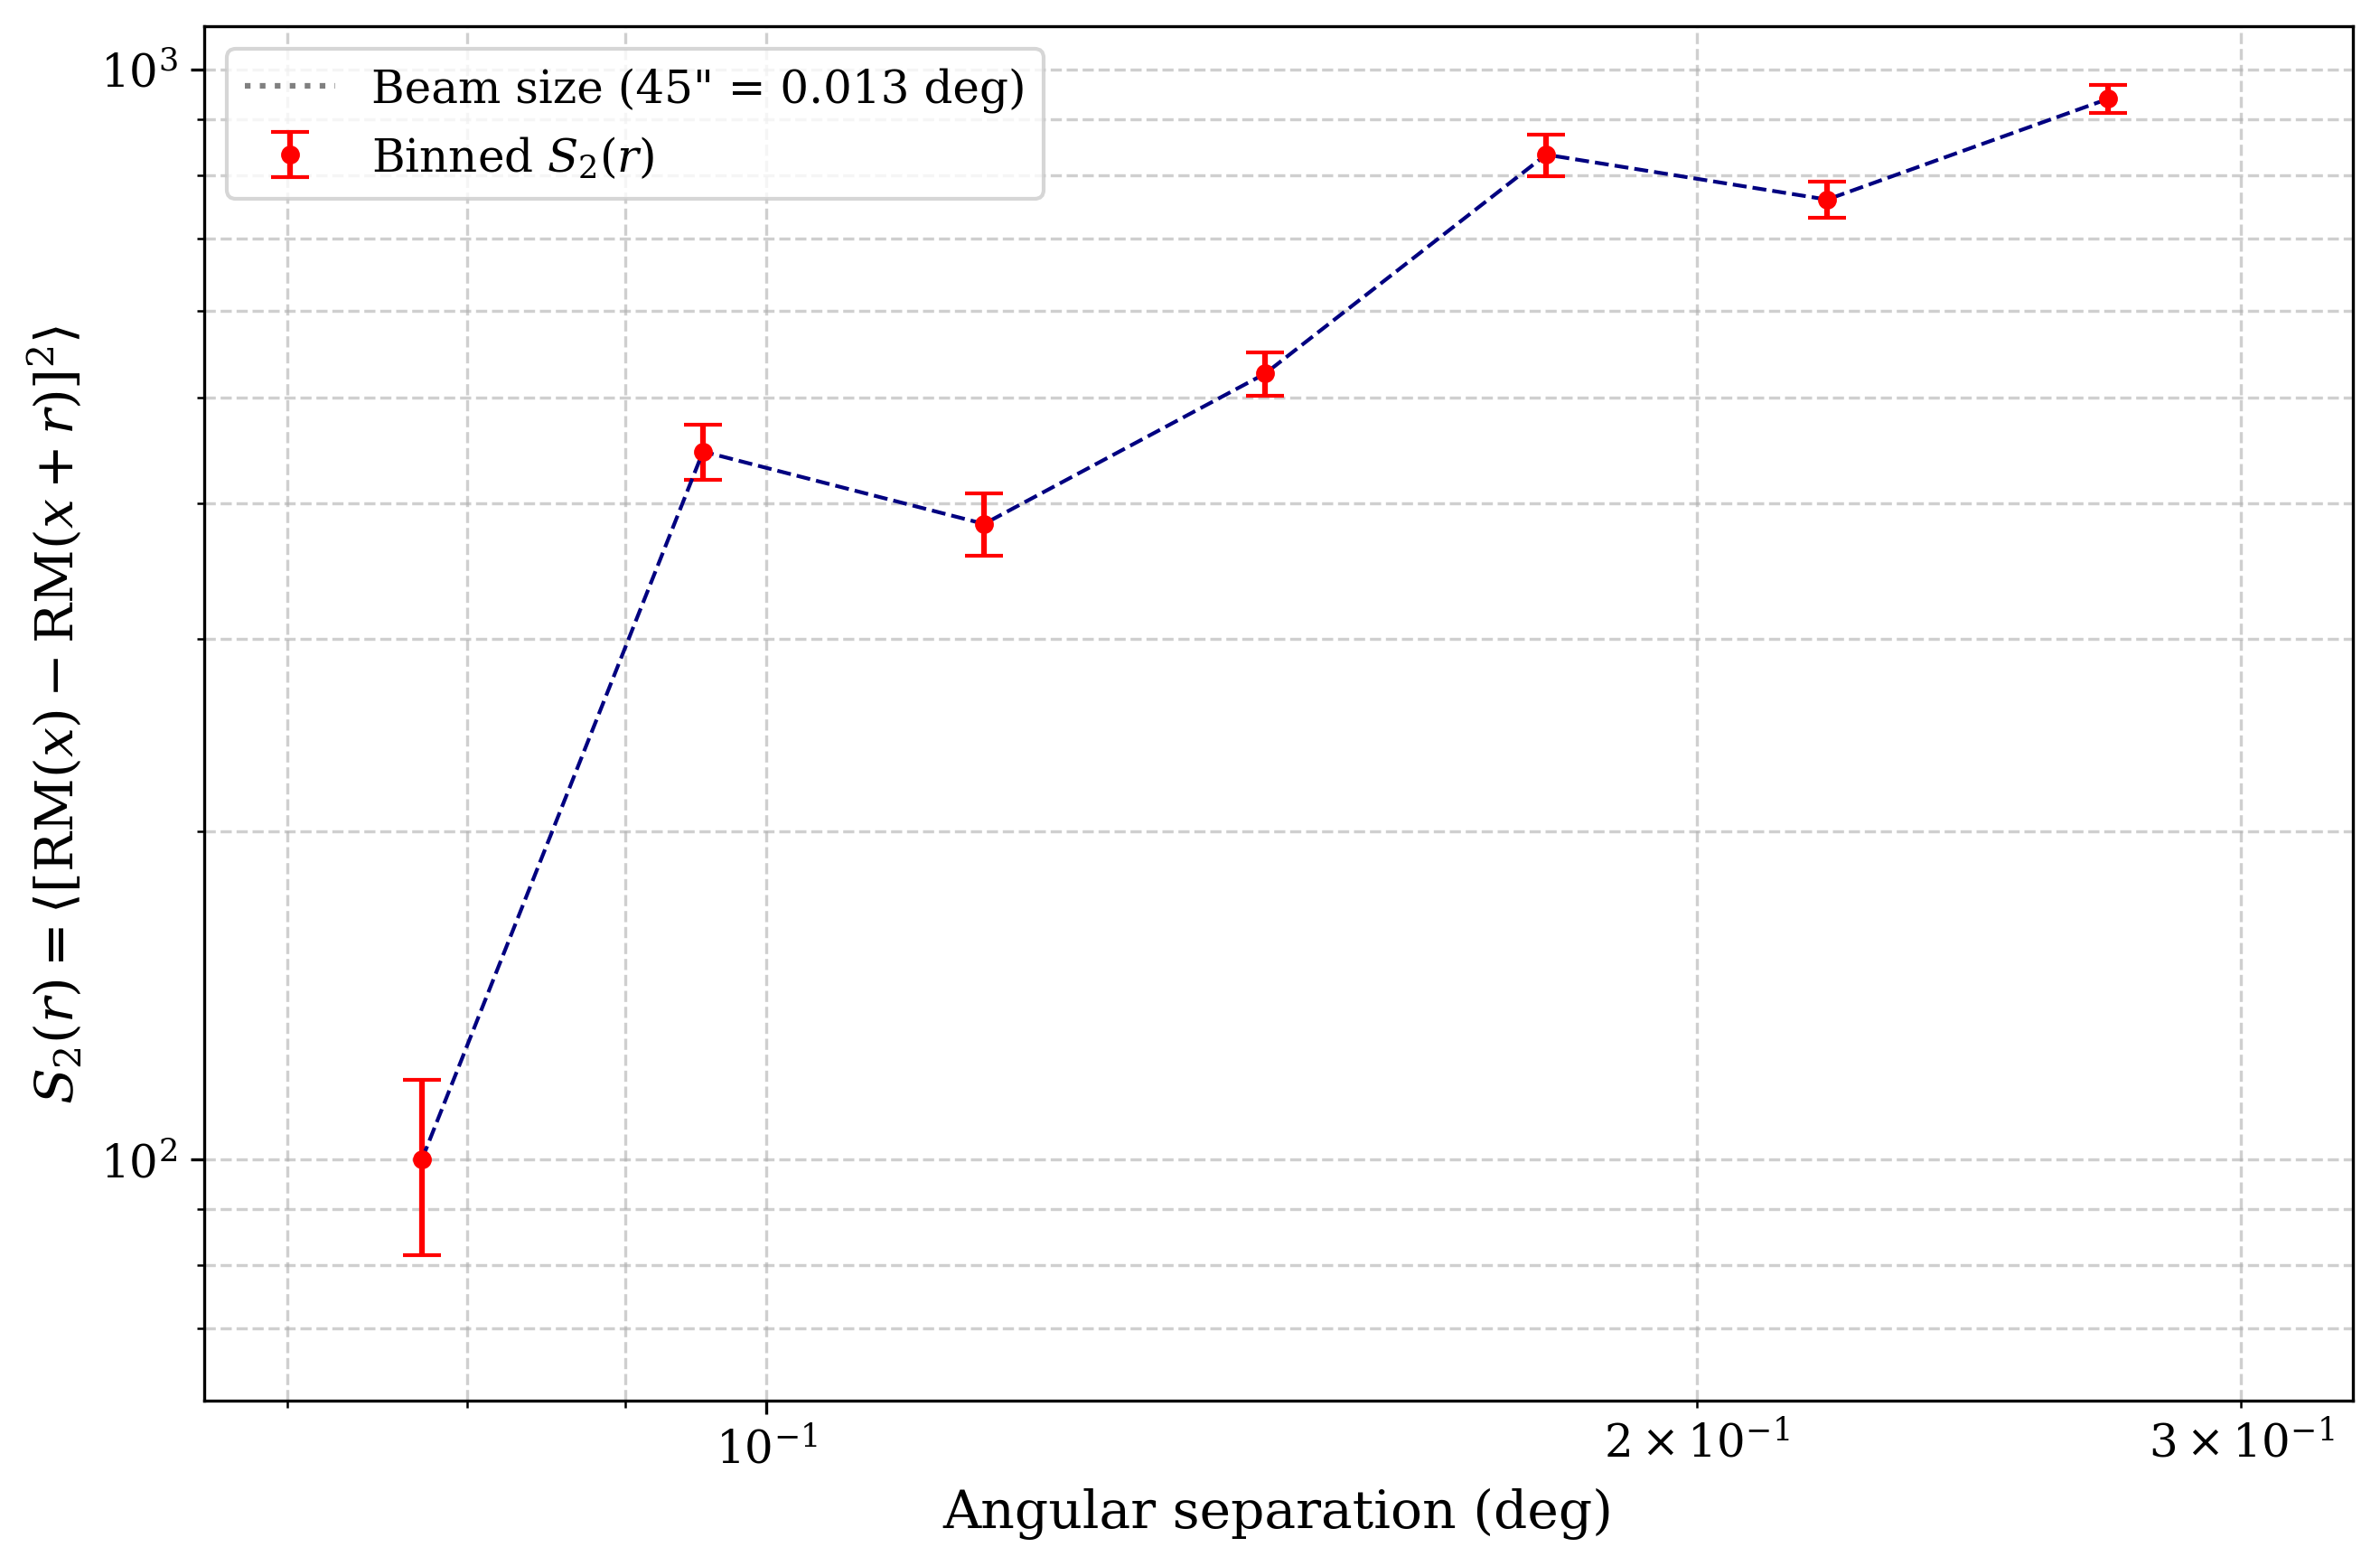

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import cKDTree

# === Load RM Catalog with uncertainty ===
rm_df = pd.read_csv("true_detections_full.csv")
rm_df = rm_df[['RA', 'Dec', 'RM', 'dRM']]
print(f"Total RMs: {len(rm_df)}")

# === Beam info ===
beam_arcsec = 45
beam_deg = beam_arcsec / 3600
print(f"Beam size: {beam_arcsec} arcsec ({beam_deg:.5f} degrees)")

# === Binning ===
bin_edges_deg = np.logspace(np.log10(0.03), np.log10(0.3), 12)  # 11 bins from 0.03° to 0.3°
bin_centers_deg = 0.5 * (bin_edges_deg[:-1] + bin_edges_deg[1:])
n_bins = len(bin_edges_deg) - 1

# === Monte Carlo parameters ===
N_MC = 100
structure_matrix = []
n_pairs_list = [[] for _ in range(n_bins)]

# === Sky coordinates and KDTree ===
skycoords = SkyCoord(ra=rm_df['RA'].values * u.deg, dec=rm_df['Dec'].values * u.deg)
positions = np.vstack([skycoords.ra.deg, skycoords.dec.deg]).T
tree = cKDTree(positions)

# === Monte Carlo realizations ===
for run in range(N_MC):
    RM_perturbed = rm_df['RM'].values + np.random.normal(0, rm_df['dRM'].values)
    lags_deg = []
    diffs_squared = []

    for i in range(len(RM_perturbed)):
        idxs_in_radius = tree.query_ball_point(positions[i], r=bin_edges_deg[-1])
        for j in idxs_in_radius:
            if j == i:
                continue
            dist_deg = np.sqrt((positions[i][0] - positions[j][0])**2 + (positions[i][1] - positions[j][1])**2)
            diff_sq = (RM_perturbed[i] - RM_perturbed[j])**2
            lags_deg.append(dist_deg)
            diffs_squared.append(diff_sq)

    lags_deg = np.array(lags_deg)
    diffs_squared = np.array(diffs_squared)

    sf_this_run = []
    for i in range(n_bins):
        in_bin = (lags_deg >= bin_edges_deg[i]) & (lags_deg < bin_edges_deg[i + 1])
        n_pairs = np.sum(in_bin)
        n_pairs_list[i].append(n_pairs)
        if n_pairs > 0:
            s2 = np.mean(diffs_squared[in_bin])
        else:
            s2 = np.nan
        sf_this_run.append(s2)

    structure_matrix.append(sf_this_run)

structure_matrix = np.array(structure_matrix)

# === Average and error from realizations ===
structure_function = np.nanmean(structure_matrix, axis=0)
structure_std = np.nanstd(structure_matrix, axis=0)
n_pairs_avg = np.array([np.nanmean(p) for p in n_pairs_list])

# === Mask unreliable bins (few pairs)
min_pairs = 20
valid = (~np.isnan(structure_function)) & (n_pairs_avg >= min_pairs)

x = bin_centers_deg[valid]
y = structure_function[valid]
yerr = structure_std[valid]
n_pairs_avg = n_pairs_avg[valid]
bin_mins = bin_edges_deg[:-1][valid]
bin_maxs = bin_edges_deg[1:][valid]

# === Print structure function table ===
print(f"{'Bin':<5} {'Range (deg)':<22} {'Center (deg)':<15} {'N pairs':<10} {'S2(r)':<20} {'± Error':<10}")
print("-" * 95)
for i, (bmin, bmax, center, N, s2, err) in enumerate(zip(bin_mins, bin_maxs, x, n_pairs_avg, y, yerr)):
    print(f"{i:<5} {bmin:.4f}–{bmax:.4f}         {center:.5f}       {int(N):<10} {s2:.5e}       {err:.5e}")

# === Plot ===
plt.figure(figsize=(9, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='red', capsize=5, markersize=4, label=r'Binned $S_2(r)$')
plt.loglog(x, y, '--', color='navy', linewidth=1)

plt.axvline(beam_deg, color='gray', linestyle=':', label=f'Beam size ({beam_arcsec}\" = {beam_deg:.3f} deg)')
plt.xlabel(r"Angular separation (deg)")
plt.ylabel(r"$S_2(r) = \langle [\mathrm{RM}(x) - \mathrm{RM}(x+r)]^2 \rangle$")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.xlim(x.min() * 0.85, x.max() * 1.2)
plt.ylim(bottom=max(y.min() * 0.6, 1))
plt.tight_layout()
plt.savefig('../paper1/figs/structurefunction.png')
plt.show()

# === Optional: Save table to CSV ===
df_out = pd.DataFrame({
    'Bin': np.arange(len(x)),
    'Bin_min_deg': bin_mins,
    'Bin_max_deg': bin_maxs,
    'Bin_center_deg': x,
    'N_pairs_avg': n_pairs_avg,
    'S2': y,
    'S2_err': yerr
})
df_out.to_csv("structure_function_with_errors.csv", index=False)


# SF above and below

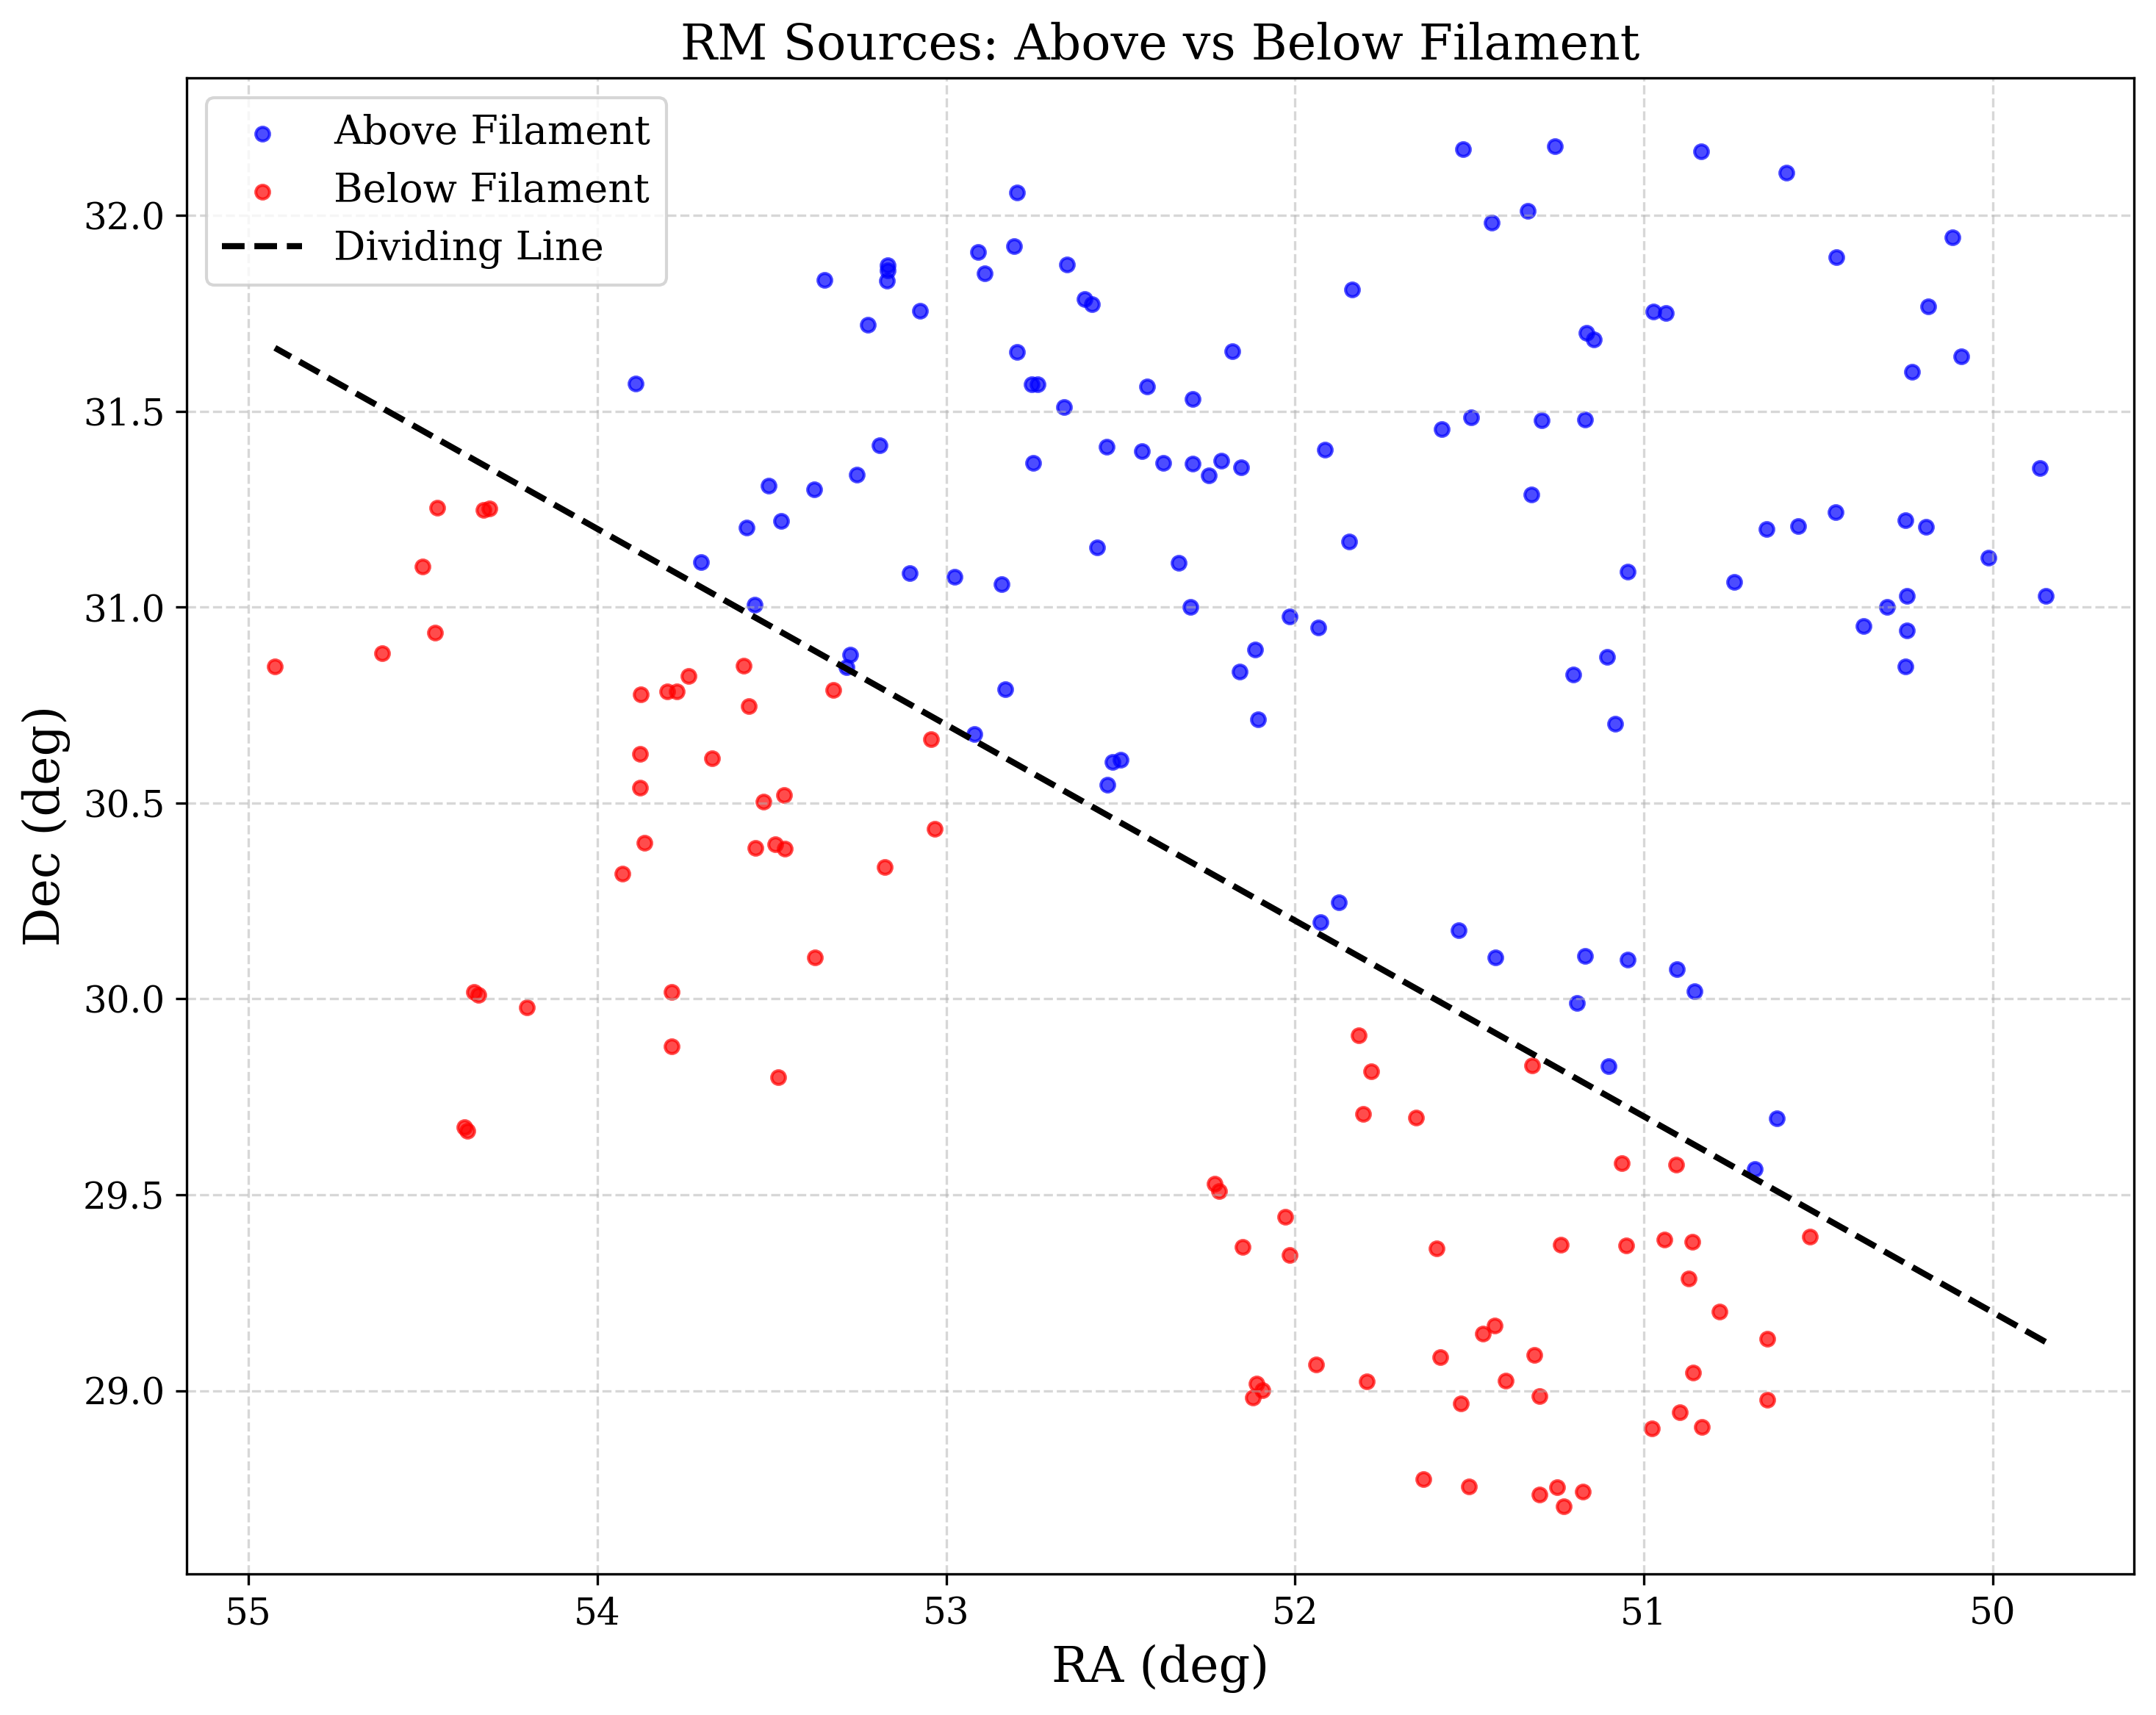

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set plot style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'legend.fontsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Step 1: Load RM sources ===
base_directory = "../paper2/"
datasets = ['23', '25', '32', '36']
all_sources = []

for dataset in datasets:
    rm_syn_dir = os.path.join(base_directory, dataset, "RMsyn")
    true_detections_file = os.path.join(rm_syn_dir, "true_detections.csv")
    if not os.path.exists(true_detections_file):
        continue
    df = pd.read_csv(true_detections_file)
    if {'RA', 'Dec', 'RM'}.issubset(df.columns):
        df['dataset'] = dataset
        all_sources.append(df[['RA', 'Dec', 'RM']])

# Combine all sources
data = pd.concat(all_sources, ignore_index=True)

# === Step 2: Classify Above/Below the Filament Line ===
def is_above_filament(ra_deg, dec_deg):
    dec_line = 0.5 * ra_deg + 4.2
    return dec_deg > dec_line

data['AboveFilament'] = is_above_filament(data['RA'], data['Dec'])

above_group = data[data['AboveFilament']]
below_group = data[~data['AboveFilament']]

# === Step 3: Plot the Positions + Dividing Line ===
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot
ax.scatter(above_group['RA'], above_group['Dec'], color='blue', label='Above Filament', s=20, alpha=0.7)
ax.scatter(below_group['RA'], below_group['Dec'], color='red', label='Below Filament', s=20, alpha=0.7)

# Plot dividing line
ra_line = np.linspace(data['RA'].min(), data['RA'].max(), 500)
dec_line = 0.5 * ra_line + 4.2
ax.plot(ra_line, dec_line, 'k--', linewidth=2, label='Dividing Line')

ax.set_xlabel('RA (deg)')
ax.invert_xaxis()
ax.set_ylabel('Dec (deg)')
ax.set_title('RM Sources: Above vs Below Filament')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../paper1/figs/split_by_filament.pdf')
plt.show()


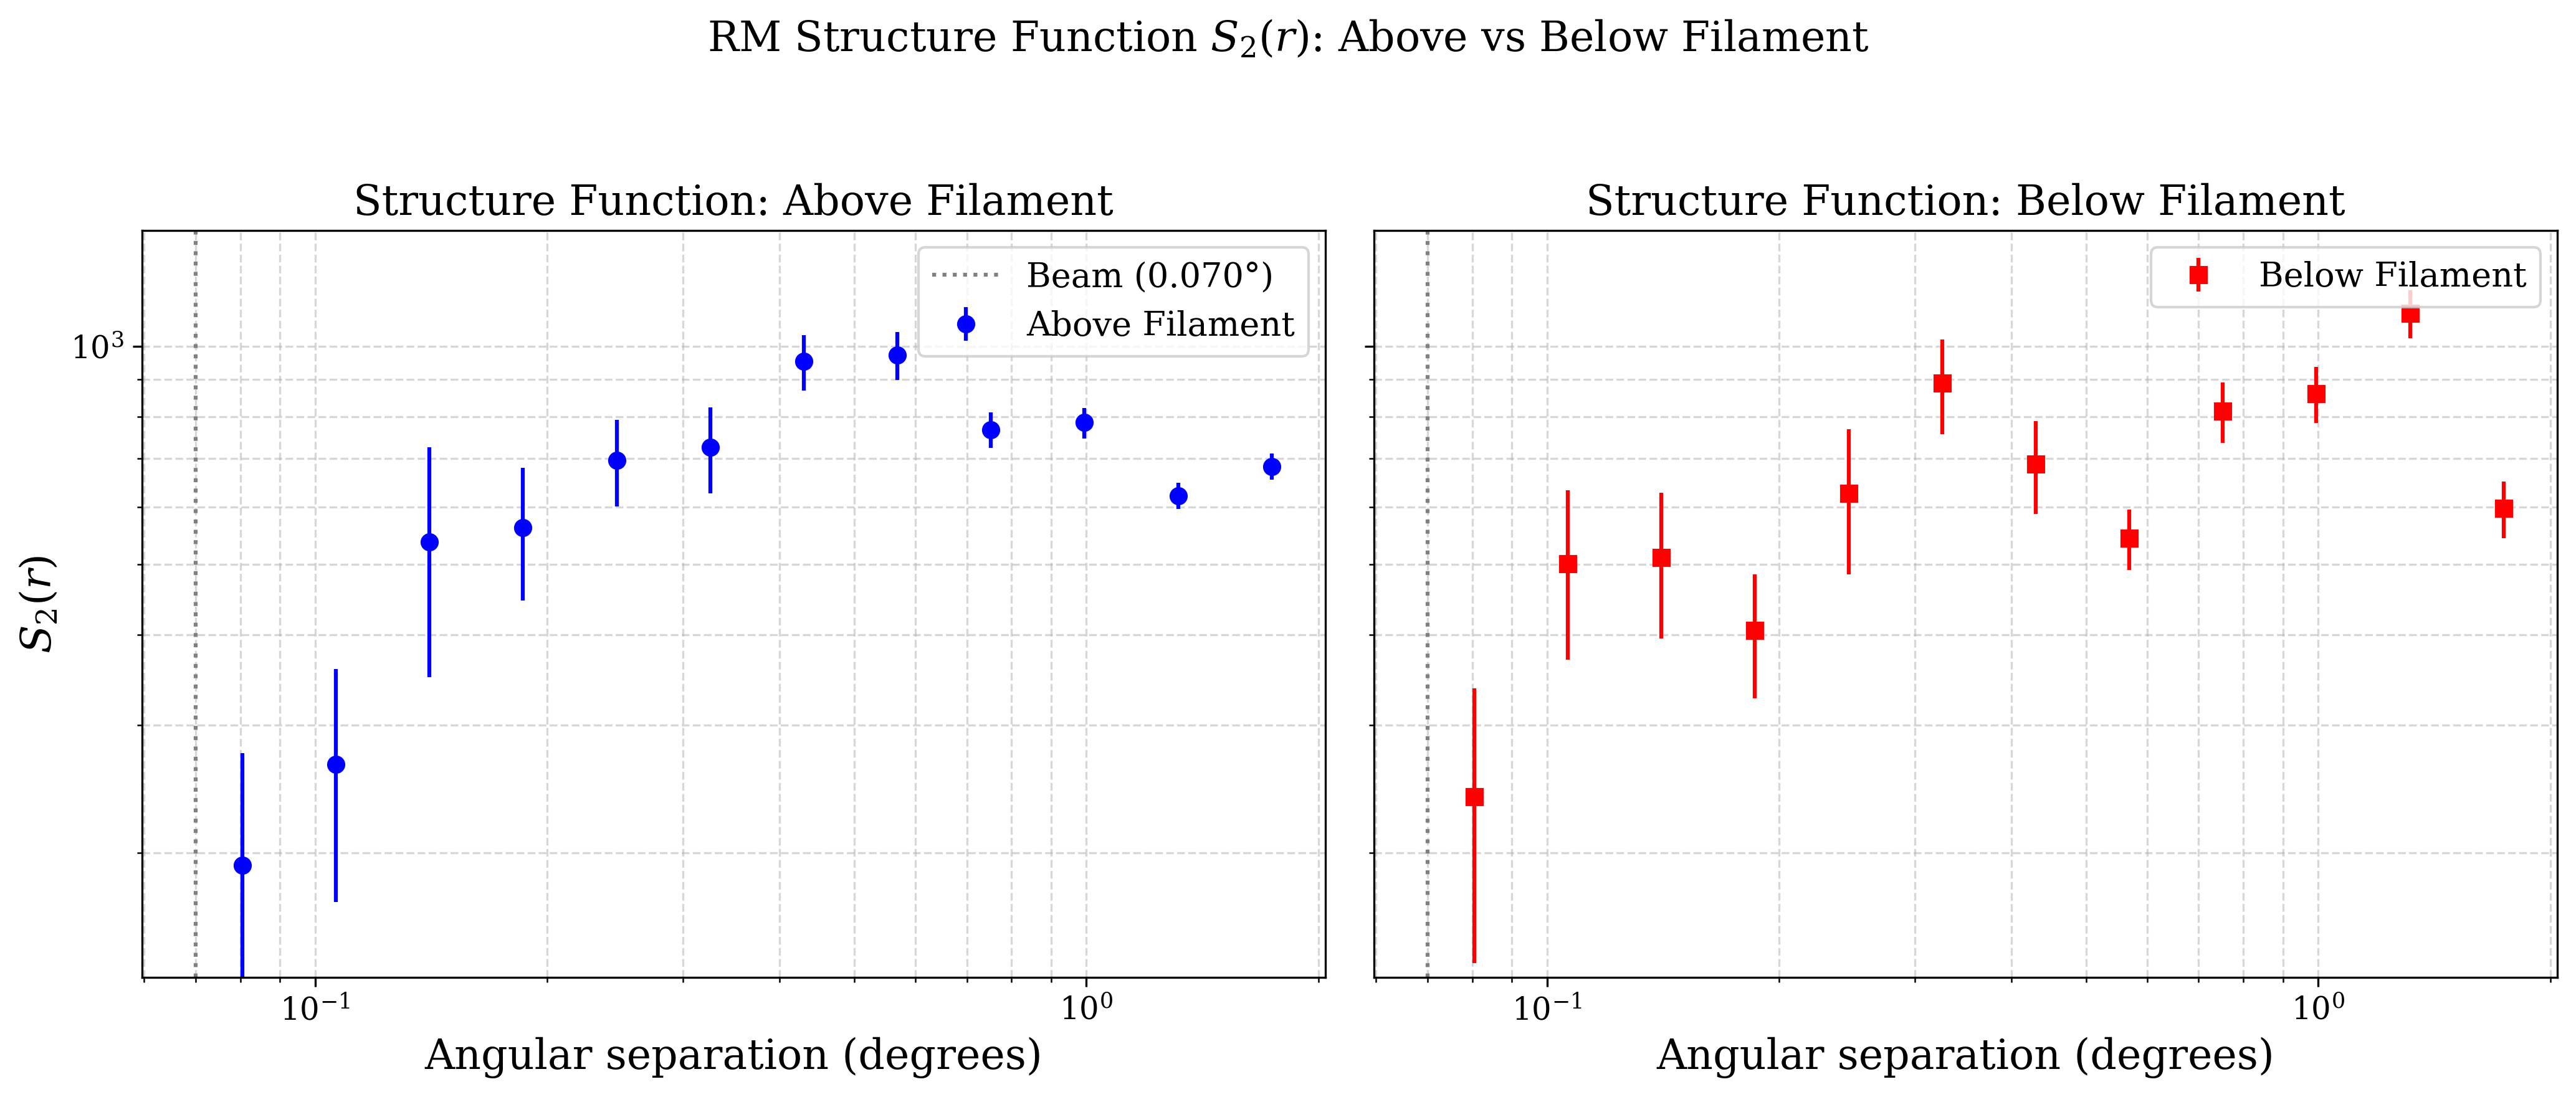

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# === Step 4: Compute Structure Functions ===
def compute_structure_function(ra, dec, rm, num_bins=12):
    coords = np.radians(np.column_stack((ra, dec)))
    dists = distance.pdist(coords, lambda u, v: np.degrees(
        np.arccos(np.sin(u[1])*np.sin(v[1]) + np.cos(u[1])*np.cos(v[1])*np.cos(u[0]-v[0]))
    ))
    rm_diffs = distance.pdist(rm[:, np.newaxis], lambda a, b: (a - b)**2)

    bins = np.logspace(np.log10(0.07), np.log10(2.0), num_bins + 1)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])
    s2 = np.zeros(num_bins)
    s2_err = np.zeros(num_bins)
    n_pairs = np.zeros(num_bins)

    for i in range(num_bins):
        mask = (dists >= bins[i]) & (dists < bins[i+1])
        if np.any(mask):
            values = rm_diffs[mask]
            s2[i] = np.mean(values)
            s2_err[i] = np.std(values) / np.sqrt(np.sum(mask))
            n_pairs[i] = np.sum(mask)
        else:
            s2[i] = np.nan
            s2_err[i] = np.nan
            n_pairs[i] = 0

    return bin_centers, s2, s2_err, n_pairs

# Compute for above and below groups
x_above, y_above, yerr_above, n_above = compute_structure_function(
    above_group['RA'].values, above_group['Dec'].values, above_group['RM'].values
)
x_below, y_below, yerr_below, n_below = compute_structure_function(
    below_group['RA'].values, below_group['Dec'].values, below_group['RM'].values
)

beam_deg = 0.07  # replace with your beam size

# === Step 5: Side-by-side Plot of Structure Functions ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Determine reasonable y-limits
valid_y = np.concatenate([y_above[np.isfinite(y_above)], y_below[np.isfinite(y_below)]])
ymin = np.nanmin(valid_y) * 0.7
ymax = np.nanmax(valid_y) * 1.3

# Plot Above Filament
axes[0].errorbar(x_above[n_above > 0], y_above[n_above > 0], yerr=yerr_above[n_above > 0],
                 fmt='o', color='blue', label='Above Filament')
axes[0].axvline(beam_deg, color='gray', linestyle=':', label=f'Beam ({beam_deg:.3f}°)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(ymin, ymax)
axes[0].set_title('Structure Function: Above Filament')
axes[0].set_xlabel("Angular separation (degrees)")
axes[0].set_ylabel(r"$S_2(r)$")
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', alpha=0.5)

# Plot Below Filament
axes[1].errorbar(x_below[n_below > 0], y_below[n_below > 0], yerr=yerr_below[n_below > 0],
                 fmt='s', color='red', label='Below Filament')
axes[1].axvline(beam_deg, color='gray', linestyle=':')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim(ymin, ymax)
axes[1].set_title('Structure Function: Below Filament')
axes[1].set_xlabel("Angular separation (degrees)")
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', alpha=0.5)

plt.suptitle(r"RM Structure Function $S_2(r)$: Above vs Below Filament", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('../paper1/figs/structurefunction_side_by_side.pdf')
plt.show()


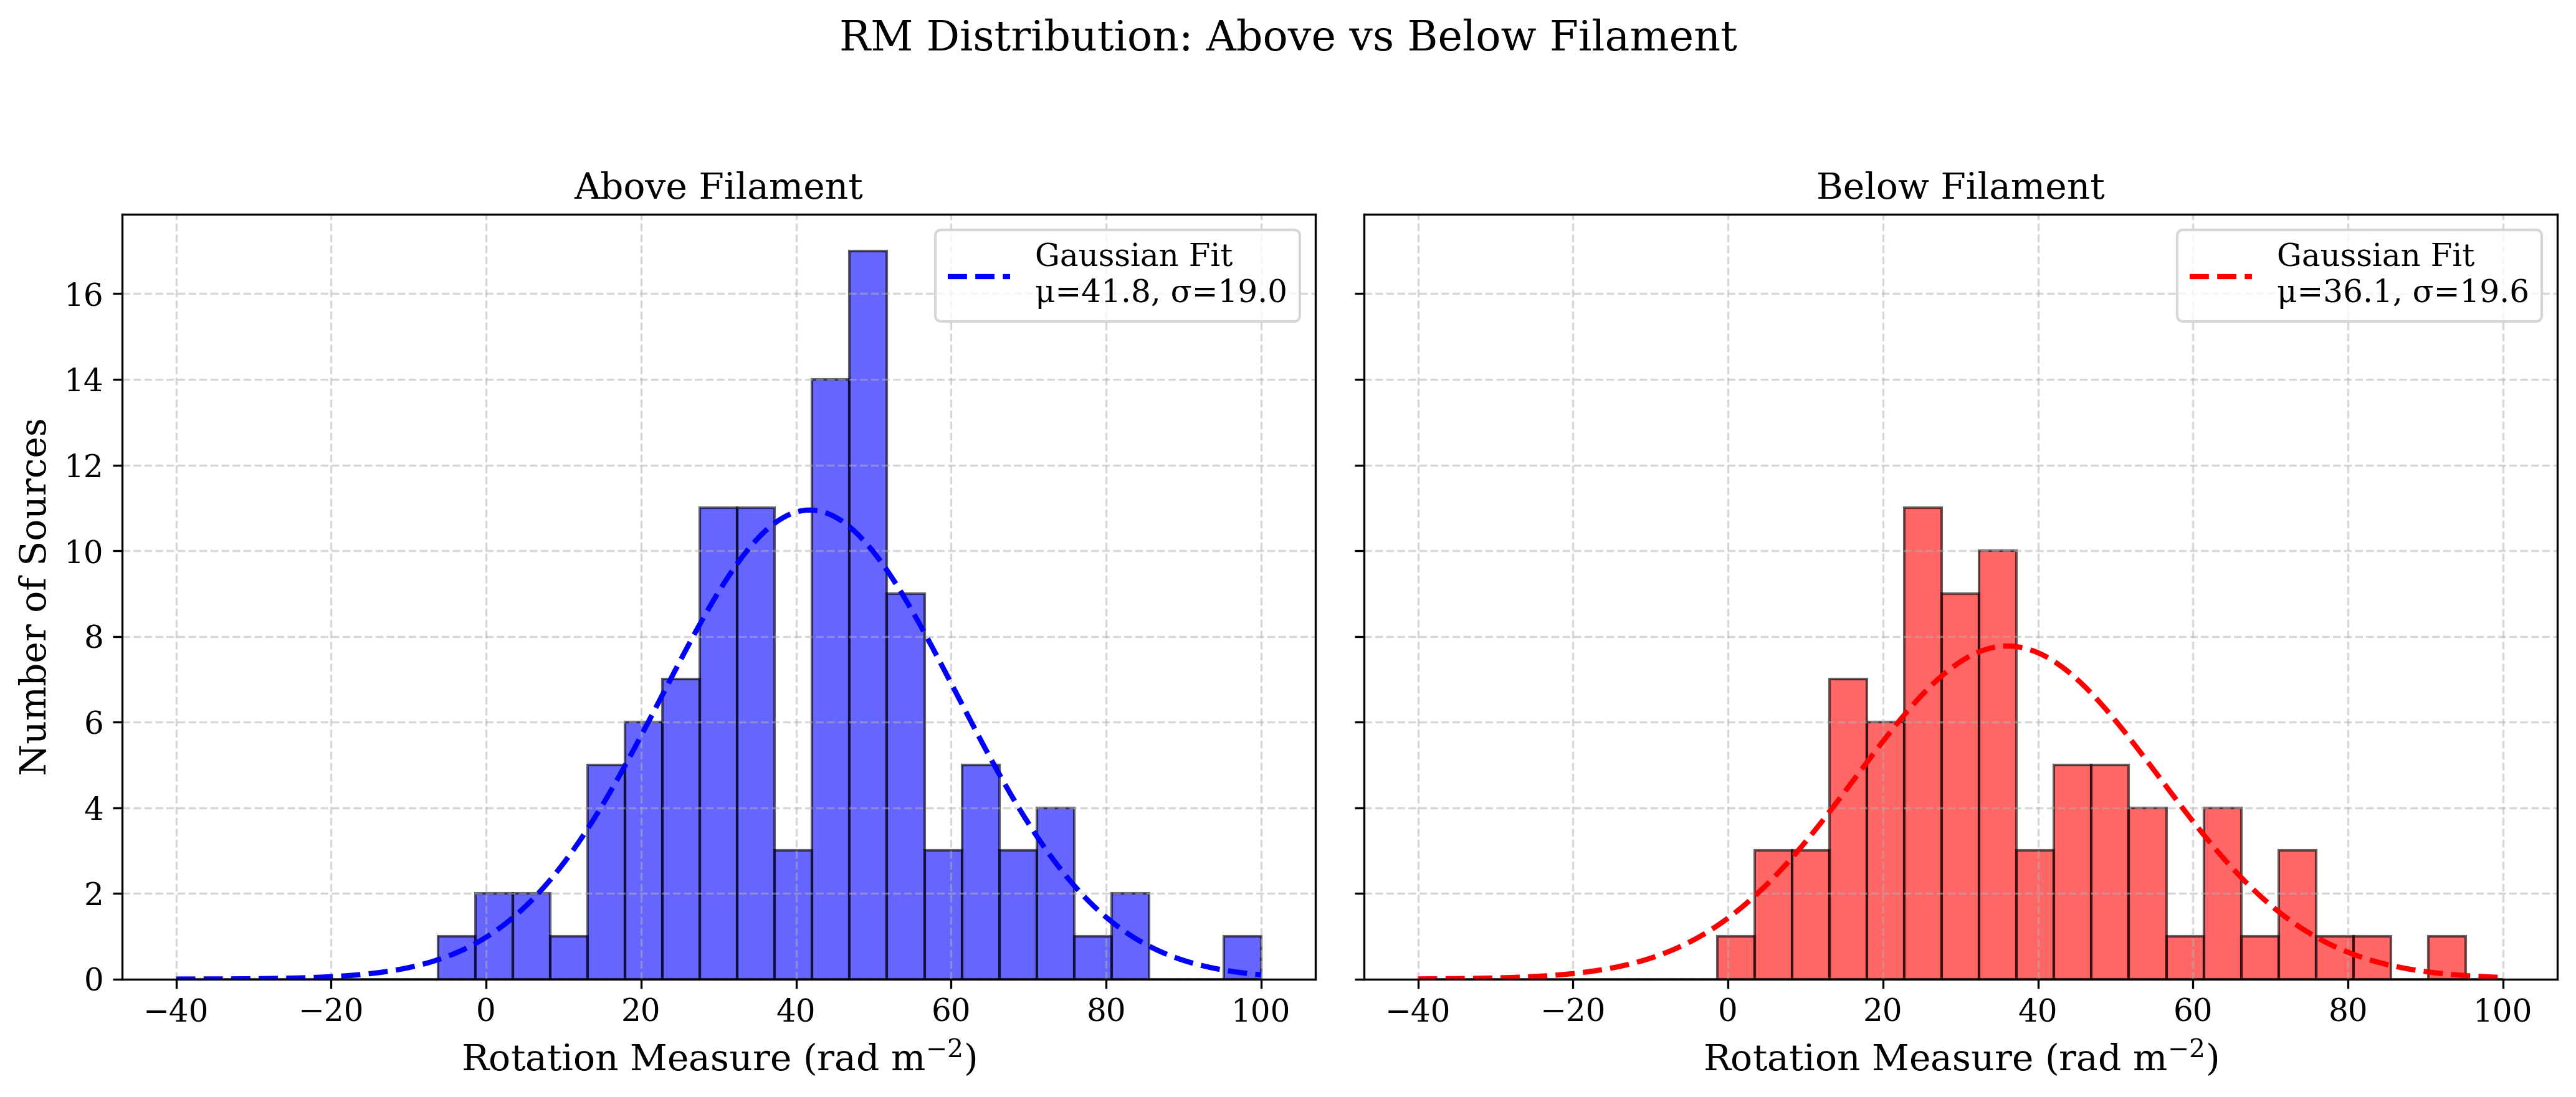

In [152]:
from scipy.stats import norm

# === Step 6: Histogram and Gaussian Fit ===

# Define RM range
rm_min, rm_max = -40, 100
bins = np.linspace(rm_min, rm_max, 30)

# Filter and extract RMs in desired range
rm_above = above_group[(above_group['RM'] >= rm_min) & (above_group['RM'] <= rm_max)]['RM']
rm_below = below_group[(below_group['RM'] >= rm_min) & (below_group['RM'] <= rm_max)]['RM']

# Fit Gaussian
mu_above, std_above = norm.fit(rm_above)
mu_below, std_below = norm.fit(rm_below)

# Generate x values for fit curve
x_fit = np.linspace(rm_min, rm_max, 500)
bin_width = bins[1] - bins[0]
gauss_above = norm.pdf(x_fit, mu_above, std_above) * len(rm_above) * bin_width
gauss_below = norm.pdf(x_fit, mu_below, std_below) * len(rm_below) * bin_width

# === Plot side-by-side ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Above
axes[0].hist(rm_above, bins=bins, color='blue', alpha=0.6, edgecolor='black')
axes[0].plot(x_fit, gauss_above, 'b--', linewidth=2,
             label=f'Gaussian Fit\nμ={mu_above:.1f}, σ={std_above:.1f}')
axes[0].set_title('Above Filament')
axes[0].set_xlabel('Rotation Measure (rad m$^{-2}$)')
axes[0].set_ylabel('Number of Sources')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot for Below
axes[1].hist(rm_below, bins=bins, color='red', alpha=0.6, edgecolor='black')
axes[1].plot(x_fit, gauss_below, 'r--', linewidth=2,
             label=f'Gaussian Fit\nμ={mu_below:.1f}, σ={std_below:.1f}')
axes[1].set_title('Below Filament')
axes[1].set_xlabel('Rotation Measure (rad m$^{-2}$)')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle('RM Distribution: Above vs Below Filament', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../paper1/figs/histogram_side_by_side_RM.pdf')
plt.show()


# Spectral index

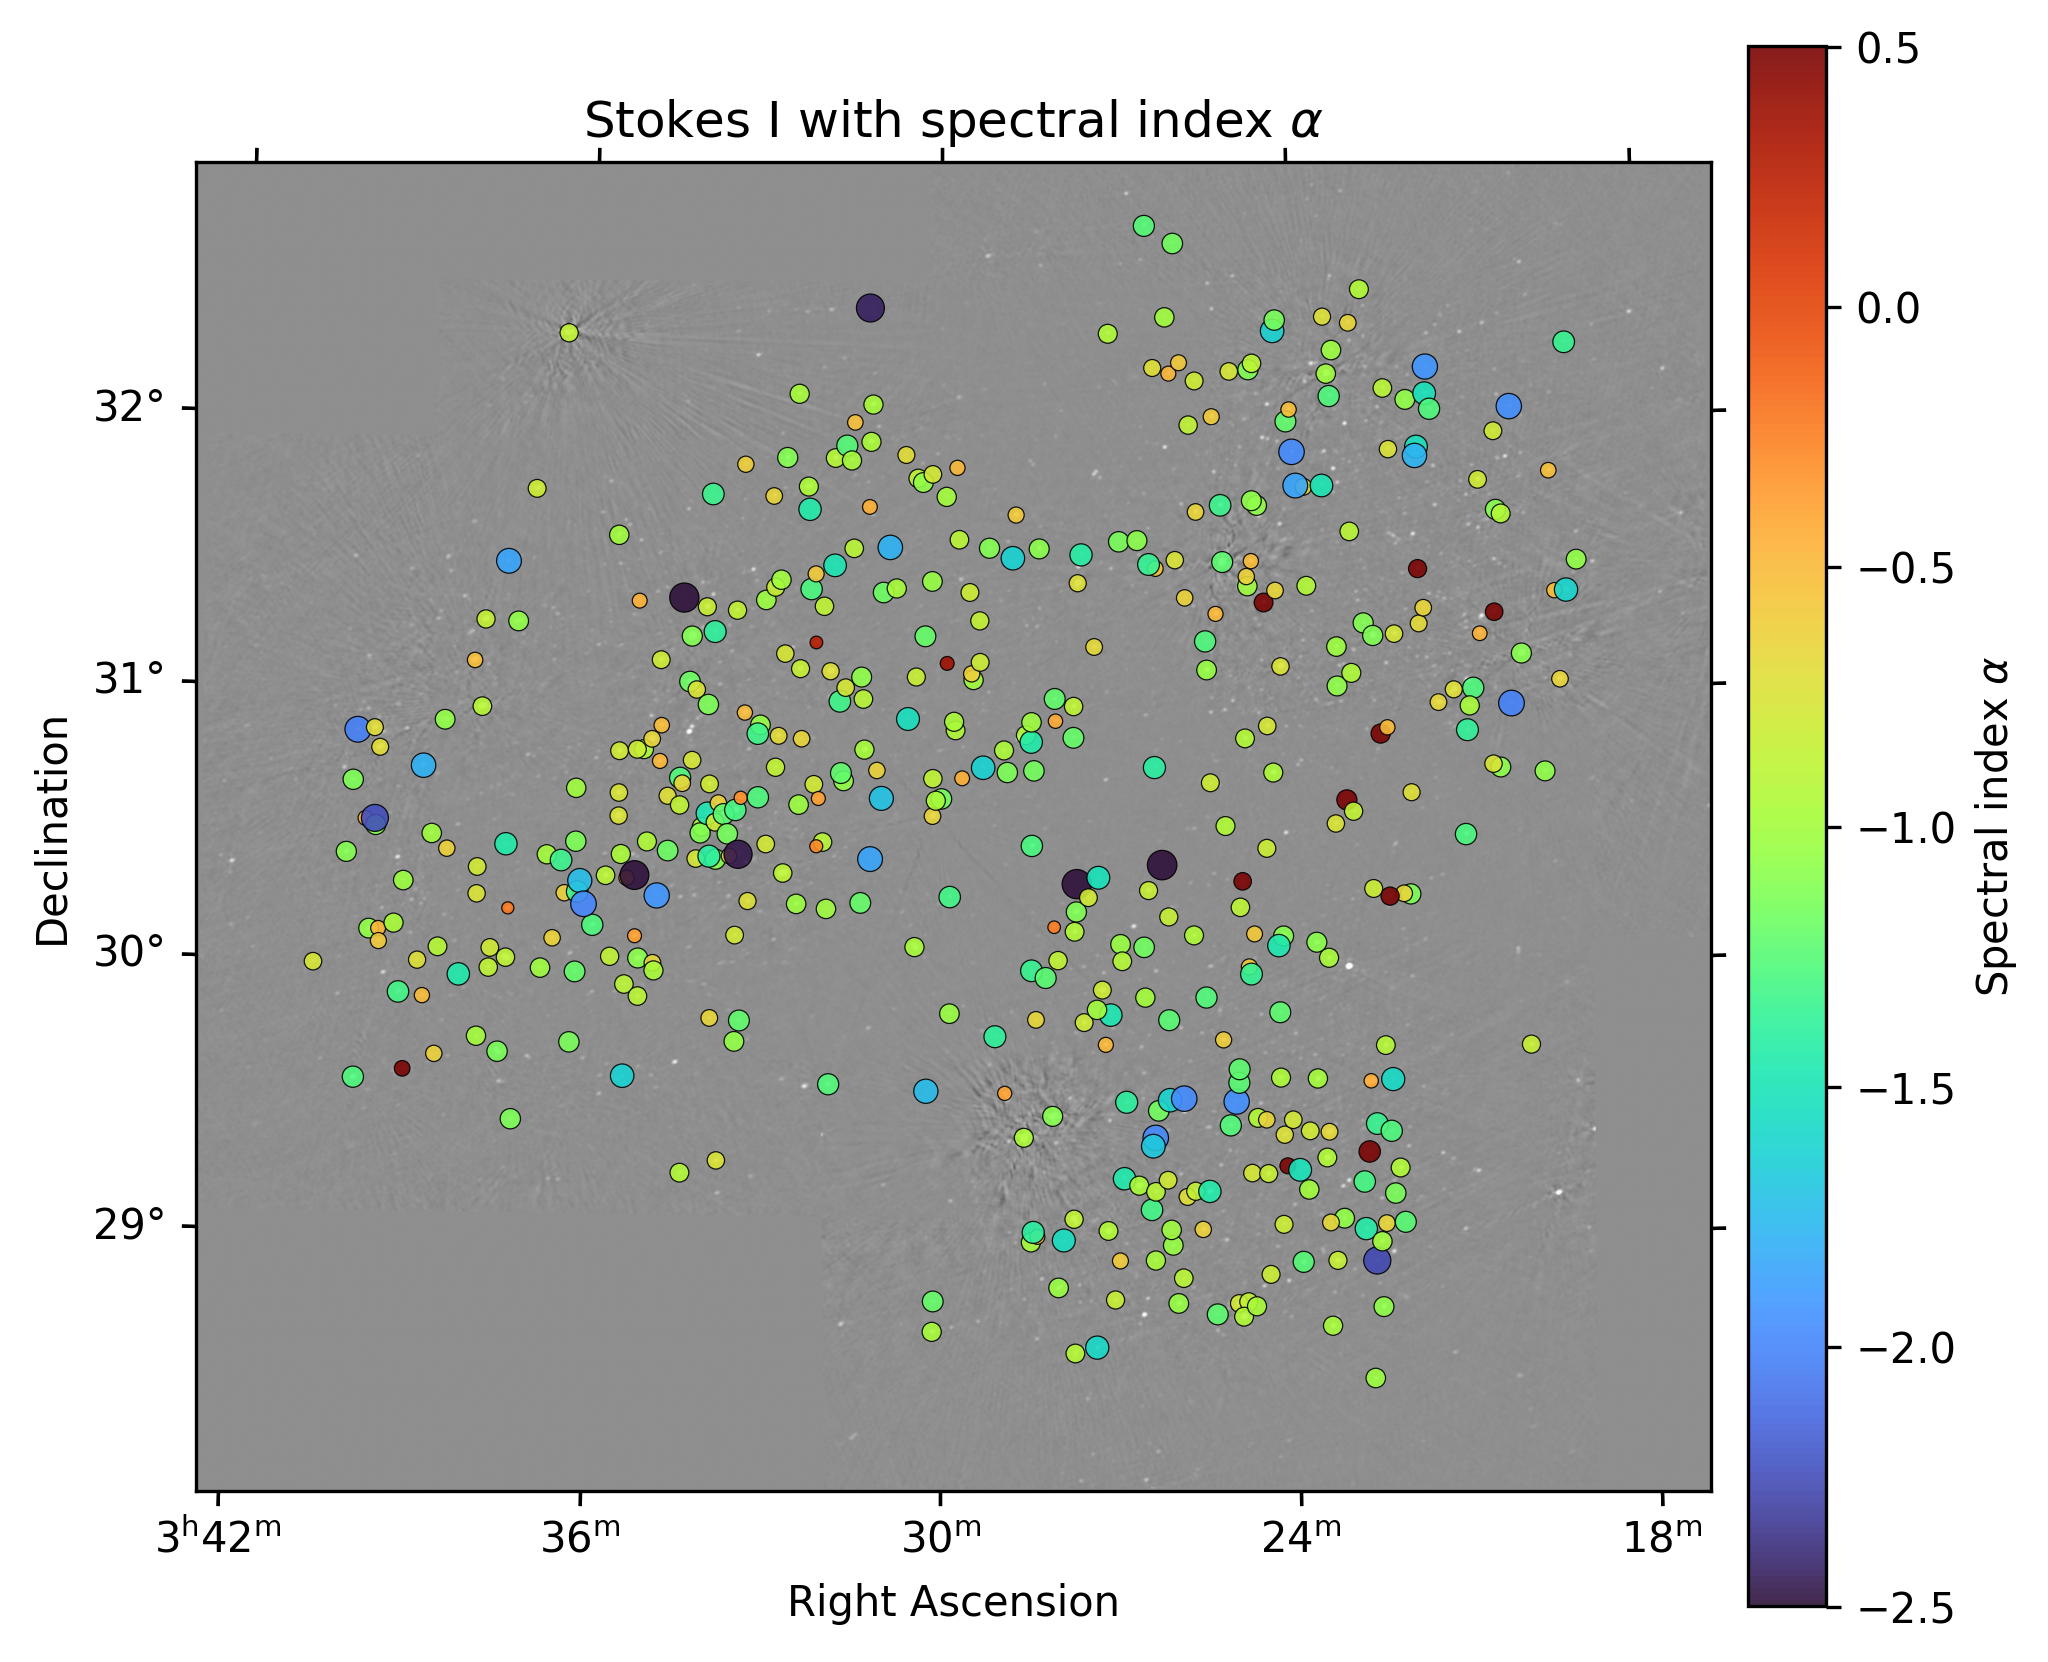

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, AsinhStretch, PercentileInterval
from matplotlib.colors import Normalize

# =========================
#  Paths
# =========================
fits_file = '../server/total/combined_result_I.fits'
combined_sources_path = '../paper1/csv/combined_sources_with_existing_alpha.csv'

# =========================
#  Load FITS (Stokes I map)
# =========================
hdul = fits.open(fits_file)
hdu = hdul[0]

# Squeeze in case of extra dimensions (e.g. (1,1,ny,nx))
data = np.squeeze(hdu.data)
wcs = WCS(hdu.header)

ny, nx = data.shape  # image size

# =========================
#  Load catalog with alpha
# =========================
df = pd.read_csv(combined_sources_path)

# Expecting columns: RA, DEC, alpha, E_alpha, ...
# Filter out rows with missing/non-finite alpha
mask_alpha = np.isfinite(df['alpha'])
df = df[mask_alpha].copy()

ra = df['RA'].values   # assumed in degrees
dec = df['DEC'].values # assumed in degrees
alpha = df['alpha'].values

# =========================
#  Convert RA/DEC to pixels
# =========================
# world_to_pixel_values works with (RA, DEC) in degrees if WCS is celestial
x_pix, y_pix = wcs.world_to_pixel_values(ra, dec)

# Keep only sources that fall inside the image boundaries
inside = (
    (x_pix >= 0) & (x_pix < nx) &
    (y_pix >= 0) & (y_pix < ny)
)

x_pix = x_pix[inside]
y_pix = y_pix[inside]
alpha = alpha[inside]

# =========================
#  Marker sizes ∝ |alpha|
# =========================
alpha_abs = np.abs(alpha)
alpha_abs_max = np.nanmax(alpha_abs)

# Avoid division-by-zero if all alphas are zero
if alpha_abs_max == 0:
    alpha_abs_max = 1.0

min_size = 5   # points^2
max_size = 50  # points^2
sizes = min_size + (alpha_abs / alpha_abs_max) * (max_size - min_size)

# =========================
#  Plot Stokes I background
# =========================
fig = plt.figure(figsize=(7, 6), dpi=300)
ax = plt.subplot(projection=wcs)

finite = np.isfinite(data)
# Clip 1% low, 99.92% high (adjust as needed)
vmin, vmax = np.nanpercentile(data[finite], [0, 99.92])

norm_im = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

im = ax.imshow(data, origin='lower', cmap='gray', norm=norm_im)

# =========================
#  Overlay alpha points
# =========================
# Use a single, wide-range colormap (no TwoSlopeNorm)
# Fixed range for alpha: [-2.5, 0.5]
alpha_vmin = -2.5
alpha_vmax = 0.5
norm_alpha = Normalize(vmin=alpha_vmin, vmax=alpha_vmax)

sc = ax.scatter(
    x_pix, y_pix,
    s=sizes,
    c=alpha,
    cmap='turbo',      # rich continuous colormap; try 'viridis' if you prefer
    norm=norm_alpha,
    edgecolors='k',
    linewidths=0.3,
    alpha=0.9
)

# Colorbar for alpha
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label(r'Spectral index $\alpha$')

# =========================
#  Axes labels, title, etc.
# =========================
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('Stokes I with spectral index $\\alpha$')

plt.tight_layout()
plt.savefig('../paper1/figs/alphamap.png')
plt.show()

hdul.close()
